# Module 2, Notebook 3: Define I/O and Get Data for original Goal

# Reminder of temporary goal to use ML to fill in missing data points

In [62]:
#Load the dataframe back into memory
import pandas as pd

# File path to the Parquet file
input_file = "HTEM_all_libraries.parquet"

# Read the Parquet file into a DataFrame
try:
    all_libraries_df = pd.read_parquet(input_file, engine='pyarrow')
    print("DataFrame successfully loaded from Parquet file.")
except FileNotFoundError:
    print(f"The file {input_file} was not found.")
except Exception as e:
    print(f"An error occurred while reading the Parquet file: {e}")


DataFrame successfully loaded from Parquet file.


In [63]:
import matplotlib.pyplot as plt

def visualize_electronic_and_optical(libraries_df):
    """
    Visualizes:
    1. Proportion of libraries with optical and electronic data.
    2. Distribution of optical band gap and electronic conductivity.
    """
    # Ensure DataFrame is not empty
    if libraries_df.empty:
        print("The library data is empty. Cannot create visualizations.")
        return
    
    # Filter libraries with optical or electronic data
    optical_libraries = libraries_df[libraries_df['has_opt'] > 0]
    electronic_libraries = libraries_df[libraries_df['has_ele'] > 0]
    both_data_libraries = libraries_df[(libraries_df['has_opt'] > 0) & (libraries_df['has_ele'] > 0)]
    
    # Summary visualization
    categories = {
        "Optical Only": len(optical_libraries) - len(both_data_libraries),
        "Electronic Only": len(electronic_libraries) - len(both_data_libraries),
        "Both Optical and Electronic": len(both_data_libraries),
        "Neither": len(libraries_df) - len(optical_libraries) - len(electronic_libraries)
    }
    
    # Pie chart for data availability
    plt.figure(figsize=(8, 8))
    plt.pie(
        categories.values(),
        labels=categories.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=['#76c7c0', '#f88a8a', '#fbd46d', '#adb5bd']
    )
    plt.title("Proportion of Libraries with Optical and Electronic Data", fontsize=14)
    plt.show()


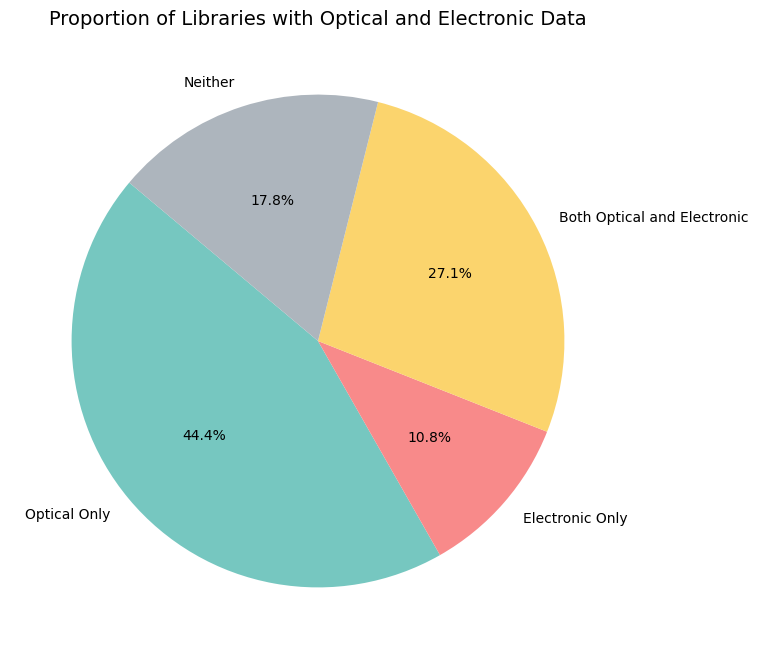

In [64]:
visualize_electronic_and_optical(all_libraries_df)

In [65]:

import pandas as pd

# File path
input_file = "Filtered_Libraries_Data_wTauc_interpolated_opt_and_xrd_dspacing.parquet"

# Read the parquet file
try:
    loaded_data = pd.read_parquet(input_file, engine='pyarrow')
    print("File successfully loaded!")
except FileNotFoundError:
    print(f"File {input_file} not found. Please ensure the file exists.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")


File successfully loaded!


In [66]:
valid_data=loaded_data

In [67]:
# Step 1: Filter valid rows

# Filter out rows with valid data
valid_data = valid_data[
    valid_data['interpolated_xrd_angle'].notna() &
    valid_data['interpolated_xrd_intensity'].notna()
]

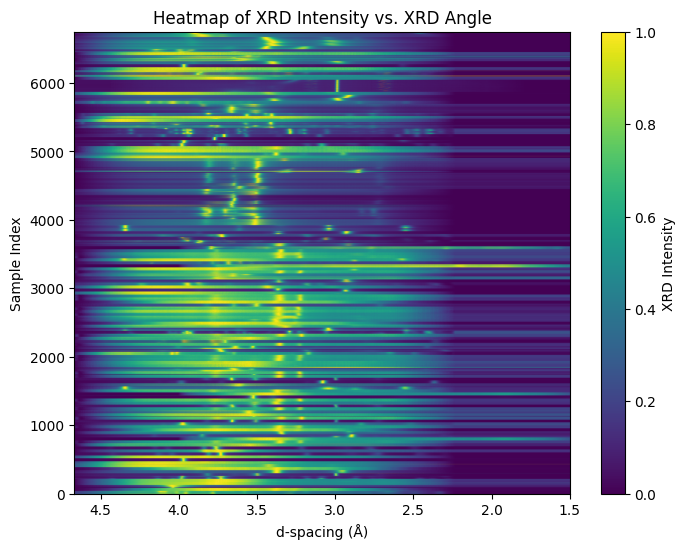

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Assume valid_data is already filtered to remove NaNs
# and that each row contains arrays for 'interpolated_xrd_angle' and 'interpolated_xrd_intensity'

# Extract the angle values from the first row (assuming they are the same for all rows)
angles = valid_data.iloc[0]['interpolated_xrd_dspacing']

# Build a 2D intensity matrix where each row corresponds to a different sample
intensity_matrix = np.stack(valid_data['interpolated_xrd_intensity'].values)

# Create the heatmap using imshow. The extent defines the x-axis limits (from first to last angle)
# and the y-axis from 0 to the number of samples.
plt.figure(figsize=(8, 6))
plt.imshow(intensity_matrix, aspect='auto',
           extent=[angles[0], angles[-1], 0, intensity_matrix.shape[0]],
           origin='lower')
plt.colorbar(label='XRD Intensity')
plt.xlabel('d-spacing (Å)')
plt.ylabel('Sample Index')
plt.title('Heatmap of XRD Intensity vs. XRD Angle')
plt.show()


In [ ]:
comment this line and execute to run model training on NN data

Epoch [100/2000], Train Loss: 0.2847, Val Loss: 0.3341
Epoch [200/2000], Train Loss: 0.2429, Val Loss: 0.3016
Epoch [300/2000], Train Loss: 0.1855, Val Loss: 0.2440
Epoch [400/2000], Train Loss: 0.1740, Val Loss: 0.2352
Epoch [500/2000], Train Loss: 0.1573, Val Loss: 0.2205
Epoch [600/2000], Train Loss: 0.1333, Val Loss: 0.1973
Epoch [700/2000], Train Loss: 0.1174, Val Loss: 0.1817
Epoch [800/2000], Train Loss: 0.1102, Val Loss: 0.1785
Epoch [900/2000], Train Loss: 0.1056, Val Loss: 0.1758
Epoch [1000/2000], Train Loss: 0.1027, Val Loss: 0.1719
Epoch [1100/2000], Train Loss: 0.0966, Val Loss: 0.1683
Epoch [1200/2000], Train Loss: 0.0882, Val Loss: 0.1670
Epoch [1300/2000], Train Loss: 0.0818, Val Loss: 0.1636
Epoch [1400/2000], Train Loss: 0.0741, Val Loss: 0.1613
Epoch [1500/2000], Train Loss: 0.0663, Val Loss: 0.1616
Epoch [1600/2000], Train Loss: 0.0626, Val Loss: 0.1594
Epoch [1700/2000], Train Loss: 0.0622, Val Loss: 0.1589
Epoch [1800/2000], Train Loss: 0.0611, Val Loss: 0.1593
E

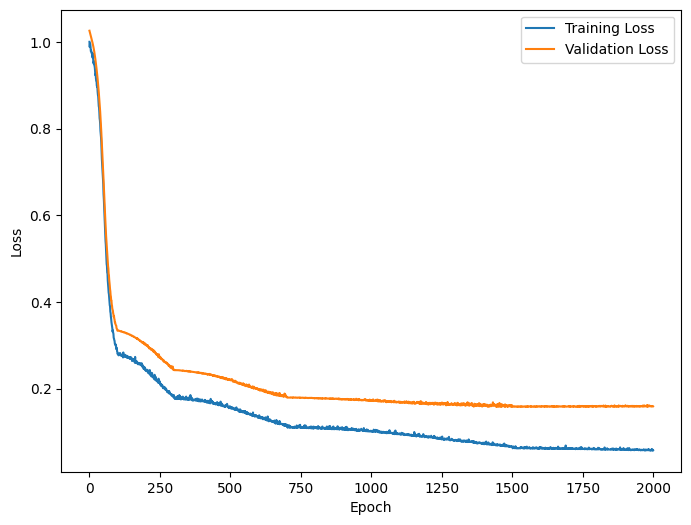

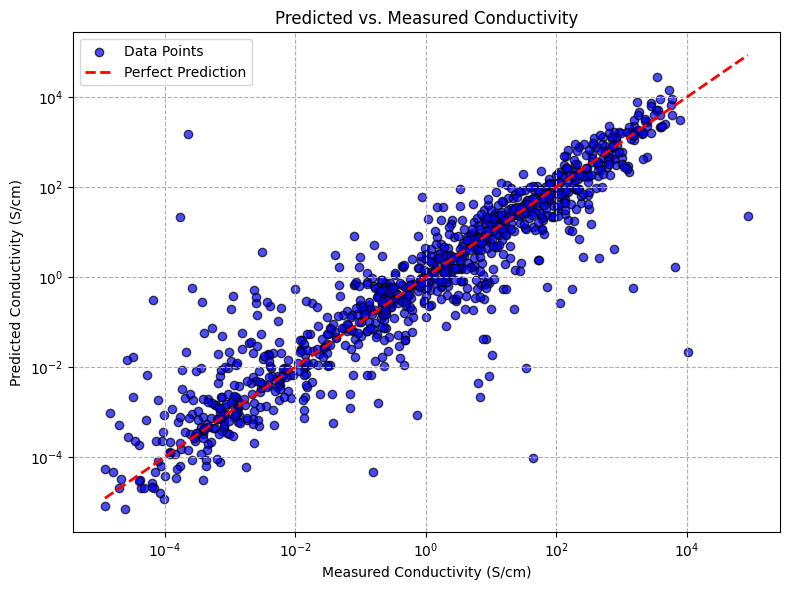

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import os

##############################################
# Declare the MLP architecture
##############################################

class OpticalXRDToConductivityMLP(nn.Module):
    def __init__(self, input_dim):
        super(OpticalXRDToConductivityMLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        y_pred = self.output(x)
        return y_pred

##############################################
# Prepare data: Combine optical and XRD data
##############################################

optical_features = []
xrd_features = []
conductivities = []

if not valid_data.empty:
    # Instead of recomputing interpolation, we use the precomputed columns:
    # 'interpolated_transmittances', 'log10_conductivity',
    # 'interpolated_xrd_intensity' (and optionally, 'interpolated_xrd_angle' or 'interpolated_xrd_dspacing')
    for _, row in valid_data.iterrows():
        # Retrieve the pre-interpolated optical data
        optical_interp = np.array(row['interpolated_transmittances'])
        # Retrieve the pre-interpolated XRD intensity data
        xrd_interp = np.array(row['interpolated_xrd_intensity'])
        # Retrieve the log10 conductivity value
        log_cond = row['log10_conductivity']

        # Append data only if the optical and XRD arrays are non-empty
        if optical_interp.size > 0 and xrd_interp.size > 0:
            optical_features.append(optical_interp)
            xrd_features.append(xrd_interp)
            conductivities.append(log_cond)

# Combine features: we horizontally stack the optical and XRD features
X = np.hstack((optical_features, xrd_features))
y = np.array(conductivities, dtype=np.float32)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

##############################################
# Create model instance and set up optimization
##############################################

input_dim = X_train_tensor.shape[1]
net = OpticalXRDToConductivityMLP(input_dim)

learning_rate = 0.000001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2, eta_min=1e-5)
criterion = nn.MSELoss()

# TensorBoard setup
writer = SummaryWriter()

# Model save directory
model_save_dir = "./final_xrd_opt_to_conductivity_models"
os.makedirs(model_save_dir, exist_ok=True)

##############################################
# Train the model
##############################################

num_epochs = 2000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation loss
    net.eval()
    with torch.no_grad():
        val_outputs = net(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    # Log to TensorBoard
    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/validation', val_loss.item(), epoch)
    writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)

    # Scheduler step
    scheduler.step()

    # Save the model and print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(net.state_dict(), f"{model_save_dir}/model_epoch_{epoch + 1}.pth")
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss.item():.4f}')

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##############################################
# Evaluate on test data
##############################################

net.eval()
with torch.no_grad():
    y_pred_tensor = net(X_test_tensor)

# Inverse transform predictions
y_pred = scaler_y.inverse_transform(y_pred_tensor.numpy().flatten().reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test_tensor.numpy().flatten().reshape(-1, 1)).flatten()

# Convert log-transformed values back to conductivity
conductivity_pred = 10 ** y_pred
conductivity_actual = 10 ** y_test

# Plot predictions
plt.figure(figsize=(8, 6))
plt.scatter(conductivity_actual, conductivity_pred, color='blue', alpha=0.7, edgecolors='k', label='Data Points')
plt.plot([conductivity_actual.min(), conductivity_actual.max()],
         [conductivity_actual.min(), conductivity_actual.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Measured Conductivity (S/cm)')
plt.ylabel('Predicted Conductivity (S/cm)')
plt.title('Predicted vs. Measured Conductivity')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

writer.close()


In [69]:
valid_data.keys()

Index(['id', 'num', 'pdac', 'quality', 'person_id', 'sample_date',
       'owner_name', 'owner_email', 'xrf_type', 'sputter_operator',
       'sample_ids', 'elements', 'xrf_elements', 'xrf_compounds',
       'deposition_sample_time_min', 'deposition_compounds',
       'deposition_power', 'deposition_base_pressure_mtorr',
       'deposition_growth_pressure_mtorr', 'deposition_target_pulses',
       'deposition_rep_rate', 'deposition_energy', 'deposition_cycles',
       'deposition_ts_distance', 'deposition_initial_temp_c', 'box_number',
       'deposition_gases', 'deposition_substrate_material',
       'deposition_gas_flow_sccm', 'has_xrd', 'has_xrf', 'has_ele', 'has_opt',
       'data_access', 'sample_library_id', 'position', 'thickness',
       'xrf_concentration', 'xrd_angle', 'xrd_background', 'xrd_intensity',
       'fpm_voltage_volts', 'fpm_current_amps', 'fpm_sheet_resistance',
       'fpm_standard_deviation', 'fpm_resistivity', 'fpm_conductivity',
       'absolute_temp_c', 'ele_

# Examine: other data available to train process model

In [4]:
import pandas as pd

# List of columns to display examples for
selected_columns = [
    "id", "num", "pdac", "quality", "person_id", "sample_date", "owner_name", "owner_email",
    "xrf_type", "sputter_operator", "sample_ids", "elements", "xrf_elements", "xrf_compounds",
    "deposition_sample_time_min", "deposition_compounds", "deposition_power",
    "deposition_base_pressure_mtorr", "deposition_growth_pressure_mtorr",
    "deposition_target_pulses", "deposition_rep_rate", "deposition_energy",
    "deposition_cycles", "deposition_initial_temp_c", "box_number",
    "deposition_gases", "deposition_substrate_material", "deposition_gas_flow_sccm",
    "has_xrd", "has_xrf", "has_ele", "has_opt", "data_access", "sample_library_id",
    "position", "thickness", "xrf_concentration"
]

# Number of examples to show per column
num_examples = 5  

# Loop through selected columns and print example values
for col in selected_columns:
    if col in valid_data.columns:
        print(f"\nColumn: {col}")
        print("-" * (8 + len(col)))  # Format the header
        
        # Show a few example values, handling lists and large objects properly
        sample_values = valid_data[col].dropna().head(num_examples).tolist()
        
        for i, val in enumerate(sample_values):
            if isinstance(val, list):
                # Convert lists to string for easy copying
                print(f"{i}: {val}")
            elif isinstance(val, float) or isinstance(val, int):
                print(f"{i}: {val}")
            elif isinstance(val, str) and len(val) > 100:
                print(f"{i}: {val[:100]}... (truncated)")
            else:
                print(f"{i}: {val}")
    else:
        print(f"\nColumn: {col} is missing from valid_data.")



Column: id
----------
0: 212251
1: 212253
2: 212252
3: 212255
4: 212254

Column: num
-----------
0: 34
1: 34
2: 34
3: 34
4: 34

Column: pdac
------------
0: 4
1: 4
2: 4
3: 4
4: 4

Column: quality
---------------
0: 3.0
1: 3.0
2: 3.0
3: 3.0
4: 3.0

Column: person_id
-----------------
0: 52.0
1: 52.0
2: 52.0
3: 52.0
4: 52.0

Column: sample_date
-------------------
0: 2013-03-05T00:00:00.000Z
1: 2013-03-05T00:00:00.000Z
2: 2013-03-05T00:00:00.000Z
3: 2013-03-05T00:00:00.000Z
4: 2013-03-05T00:00:00.000Z

Column: owner_name
------------------
0: Lauryn Baranowski
1: Lauryn Baranowski
2: Lauryn Baranowski
3: Lauryn Baranowski
4: Lauryn Baranowski

Column: owner_email
-------------------
0: l.l.baranowski@gmail.com
1: l.l.baranowski@gmail.com
2: l.l.baranowski@gmail.com
3: l.l.baranowski@gmail.com
4: l.l.baranowski@gmail.com

Column: xrf_type
----------------
0: maxxi
1: maxxi
2: maxxi
3: maxxi
4: maxxi

Column: sputter_operator
------------------------
0: Andriy
1: Andriy
2: Andriy
3: Andri

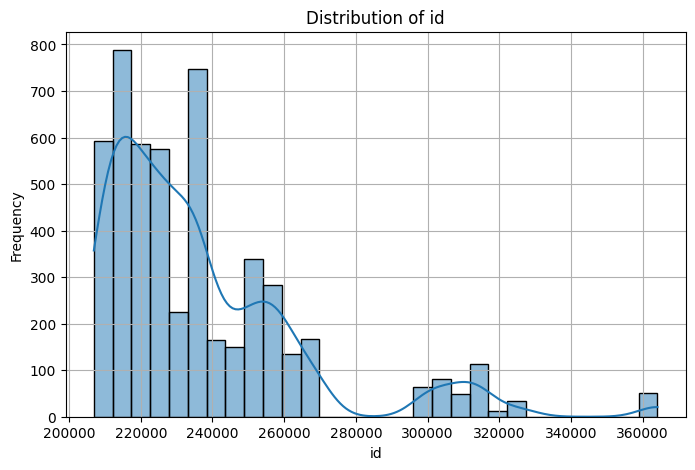

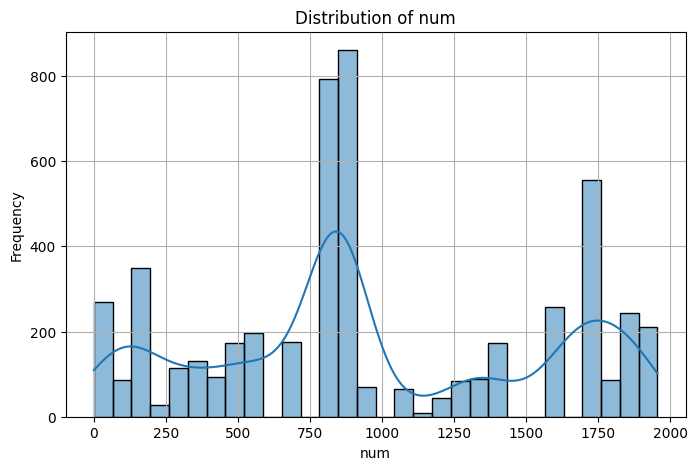

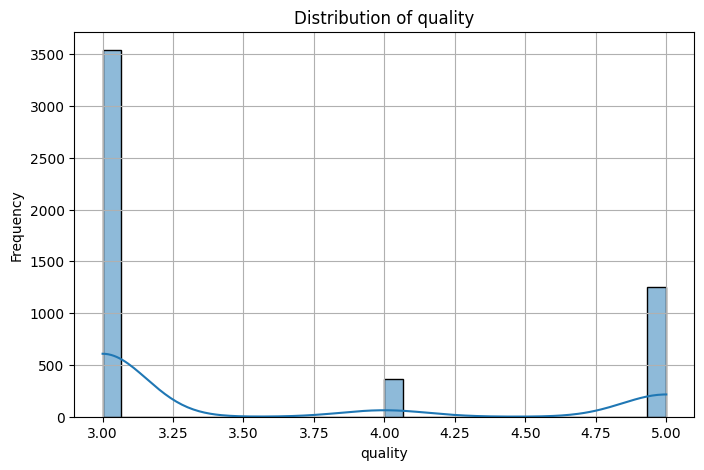

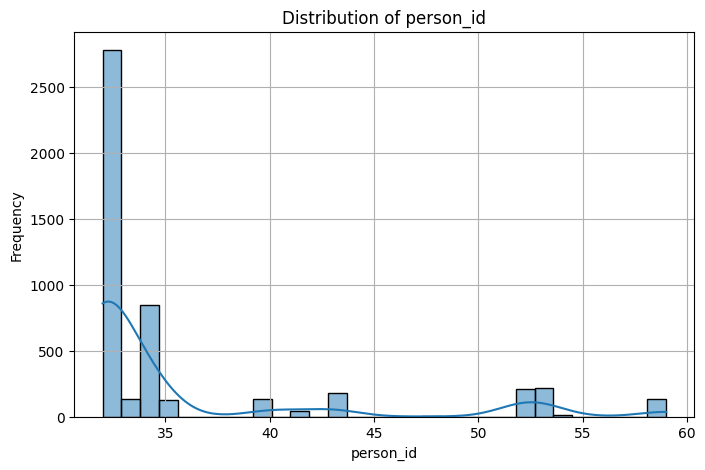

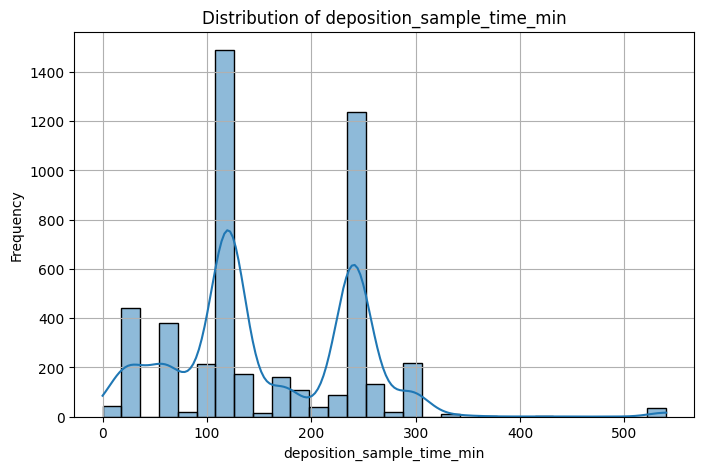

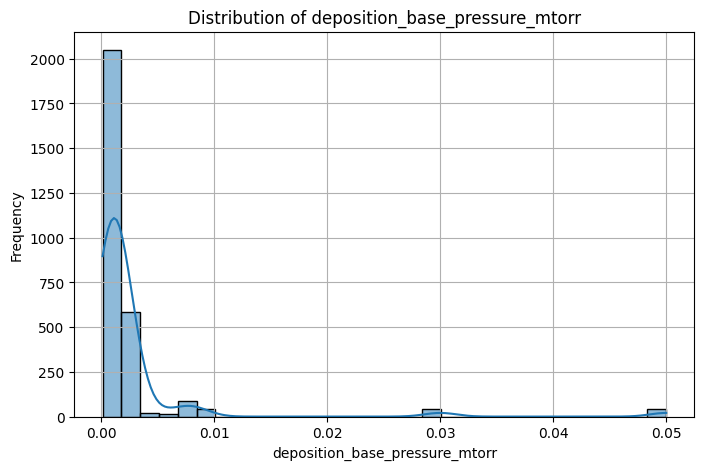

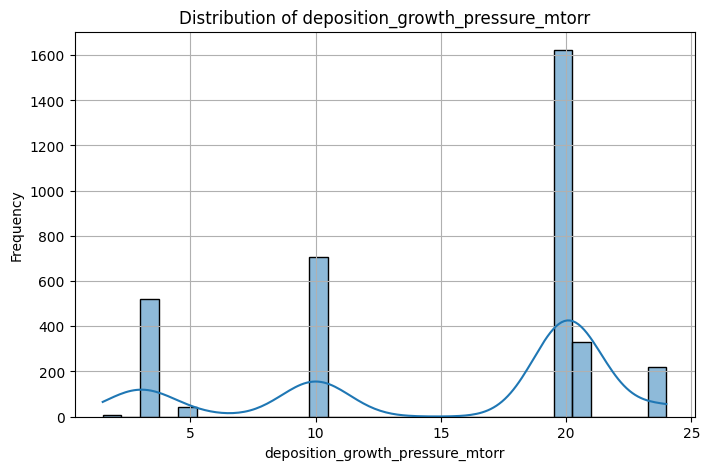

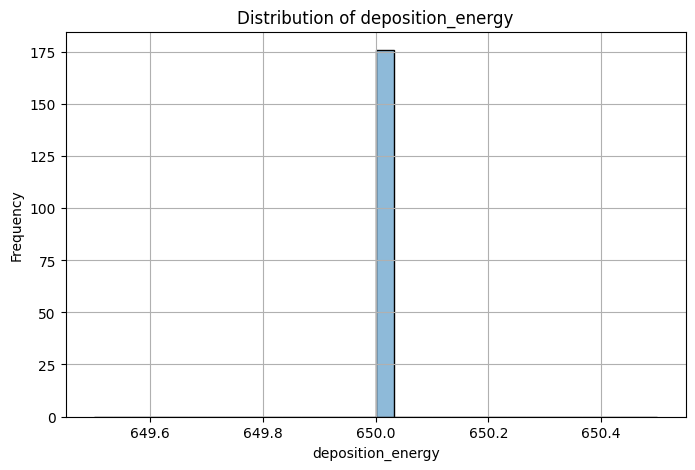

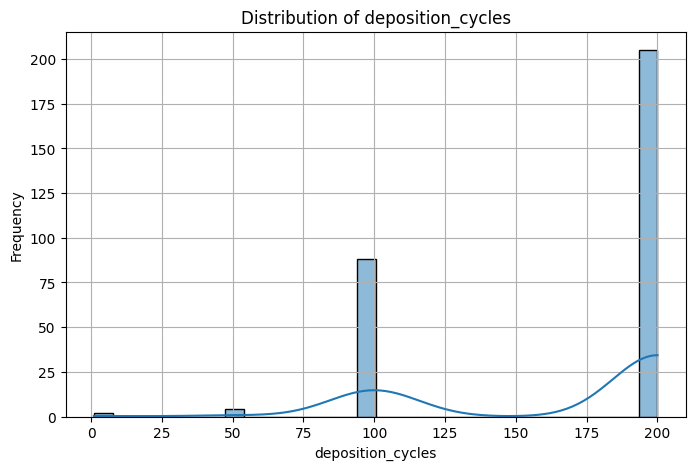

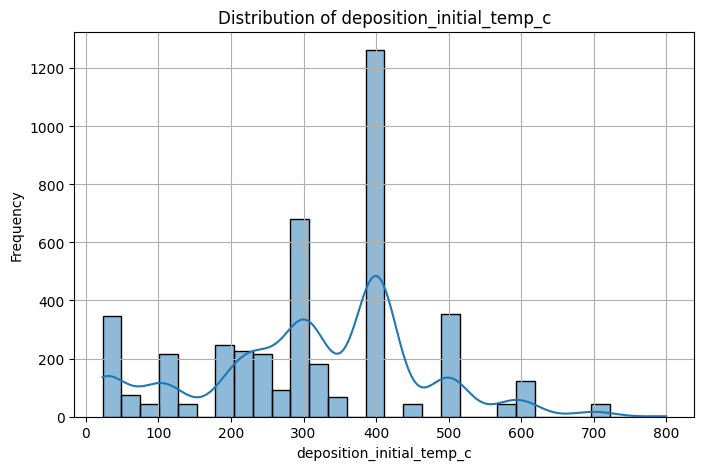

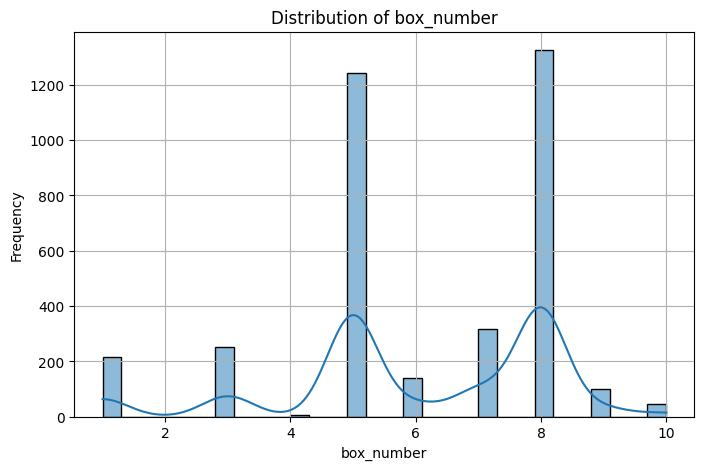

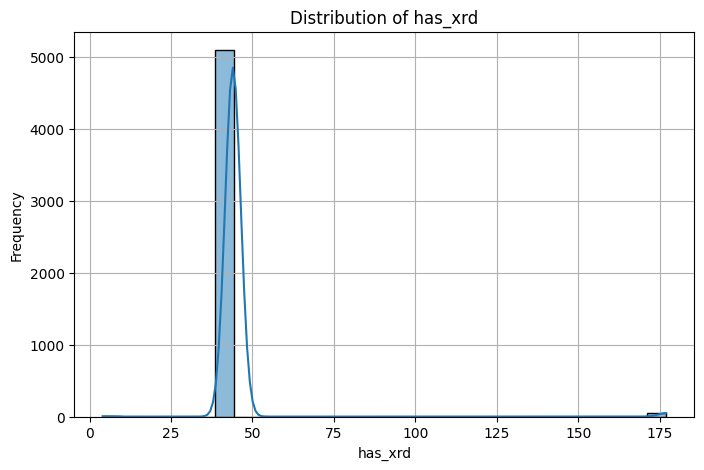

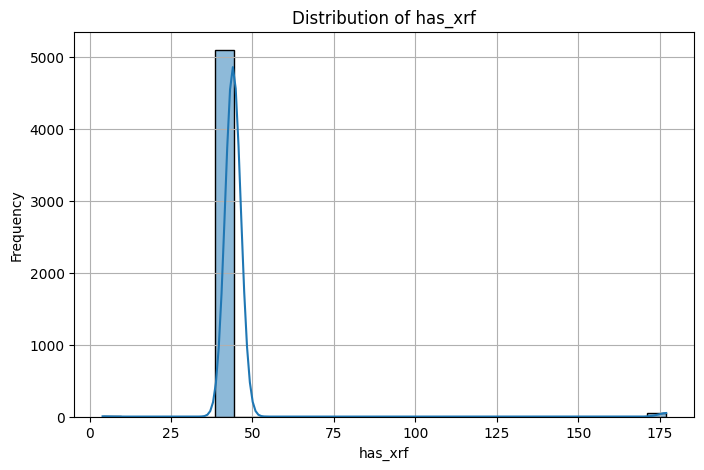

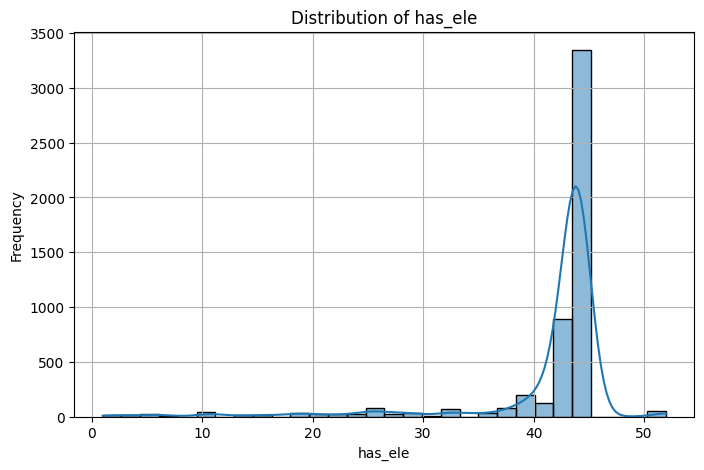

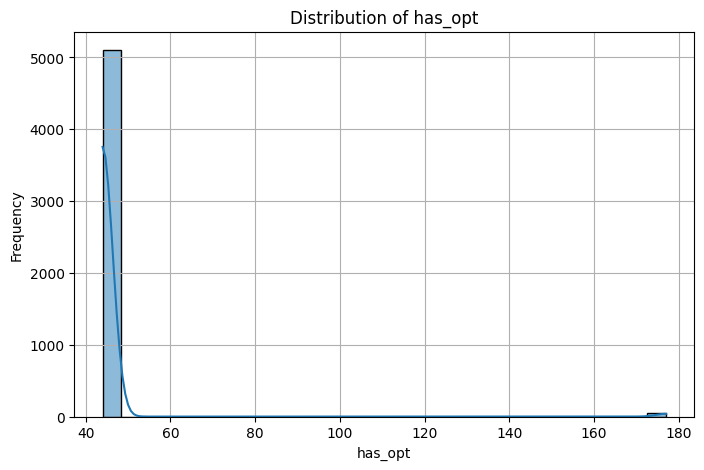

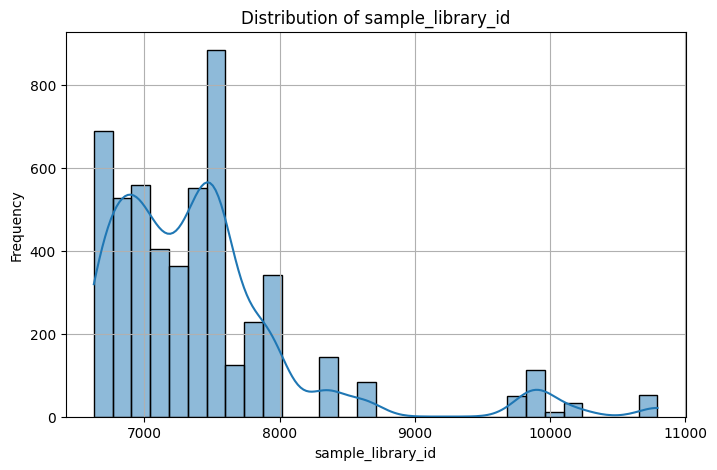

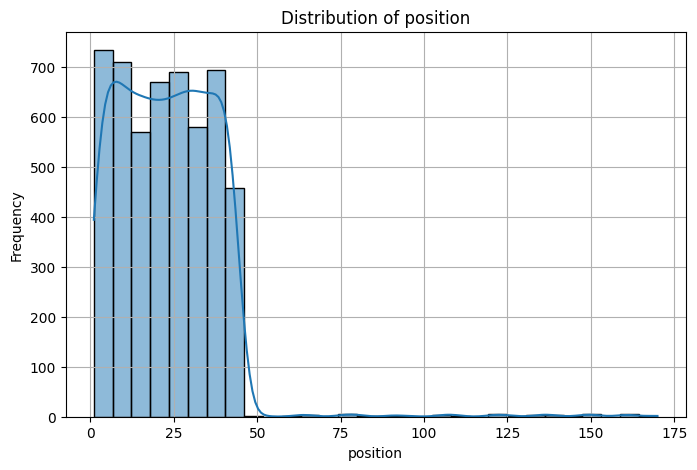

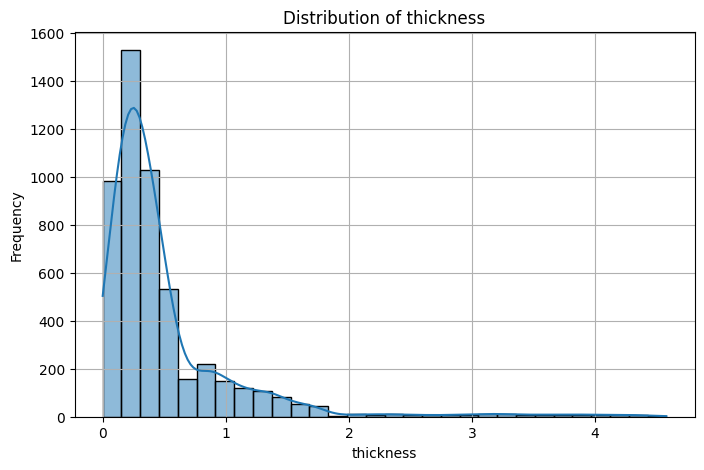

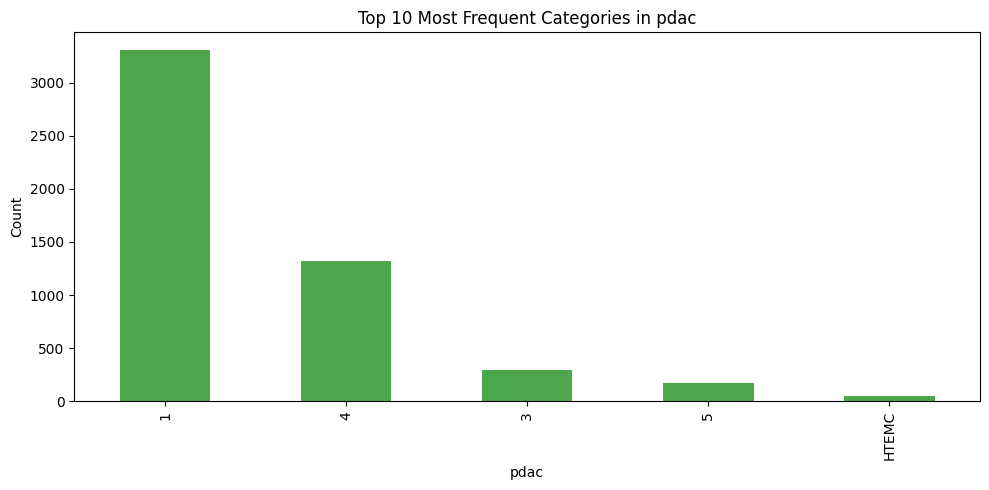

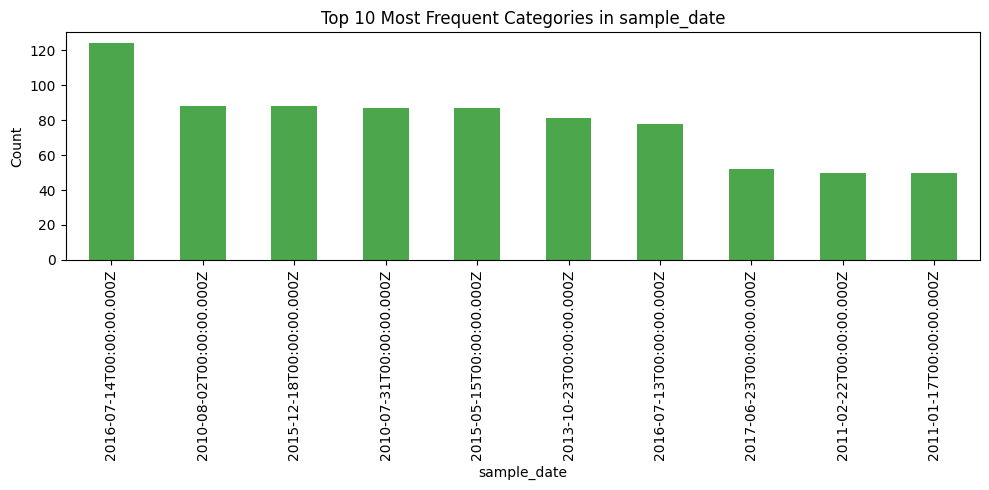

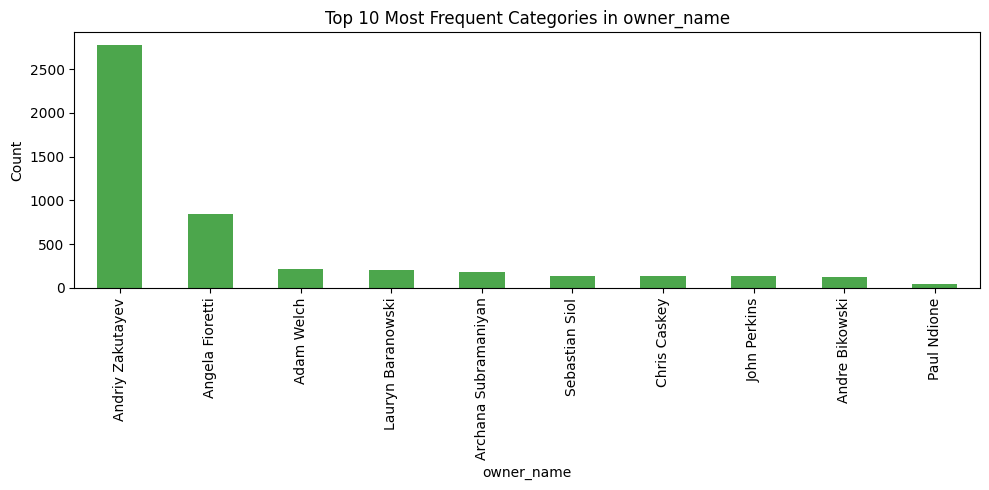

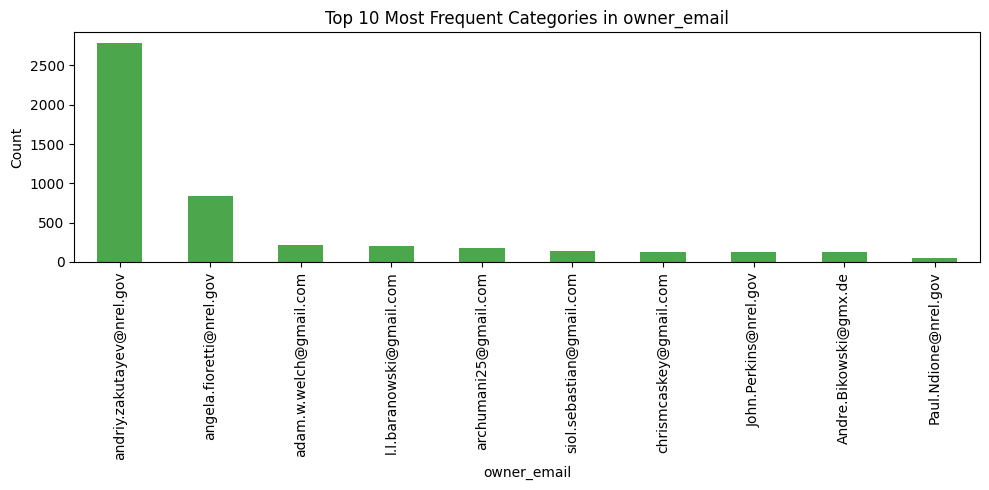

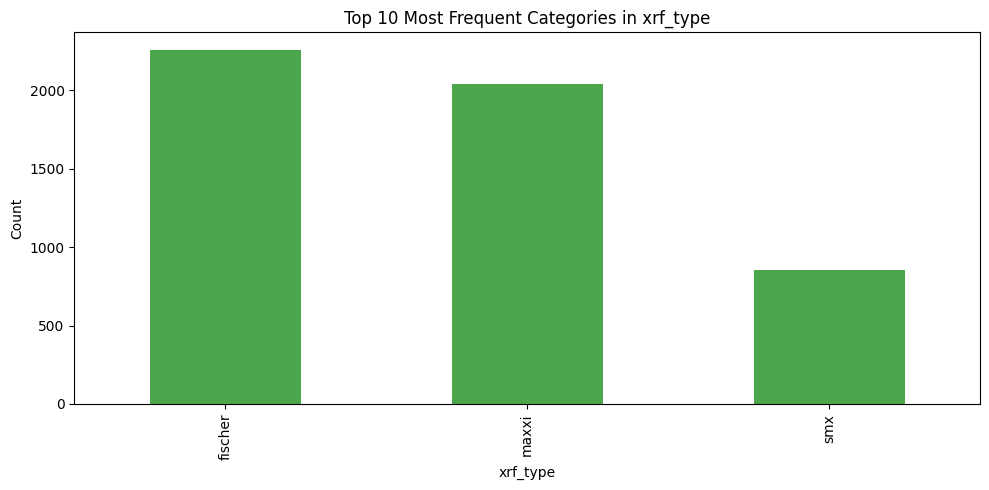

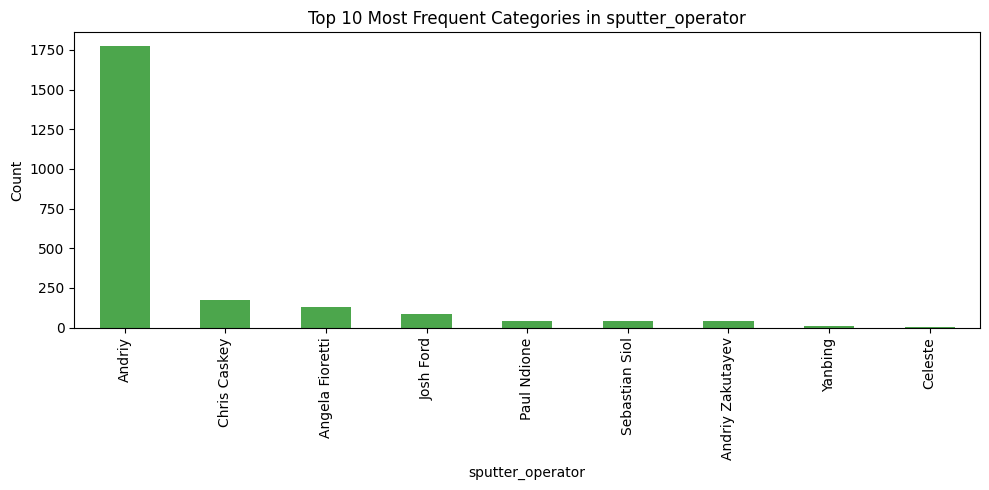

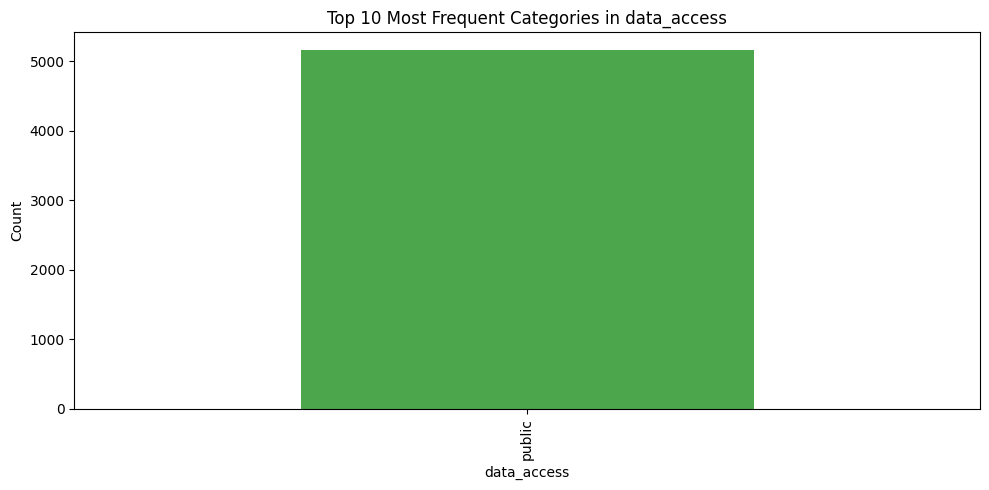

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of non-nested columns (excluding lists/arrays)
non_nested_columns = [
    "id", "num", "pdac", "quality", "person_id", "sample_date", "owner_name",
    "owner_email", "xrf_type", "sputter_operator", "deposition_sample_time_min",
    "deposition_base_pressure_mtorr", "deposition_growth_pressure_mtorr",
    "deposition_energy", "deposition_cycles", "deposition_initial_temp_c",
    "box_number", "has_xrd", "has_xrf", "has_ele", "has_opt", "data_access",
    "sample_library_id", "position", "thickness"
]

# Identify numeric and categorical columns
numeric_cols = [col for col in non_nested_columns if pd.api.types.is_numeric_dtype(valid_data[col])]
categorical_cols = [col for col in non_nested_columns if col not in numeric_cols]

# Plot histograms for numeric variables
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(valid_data[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Plot bar charts for categorical variables
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    valid_data[col].value_counts().head(10).plot(kind='bar', color='green', alpha=0.7)
    plt.title(f"Top 10 Most Frequent Categories in {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


Processing column: sample_ids


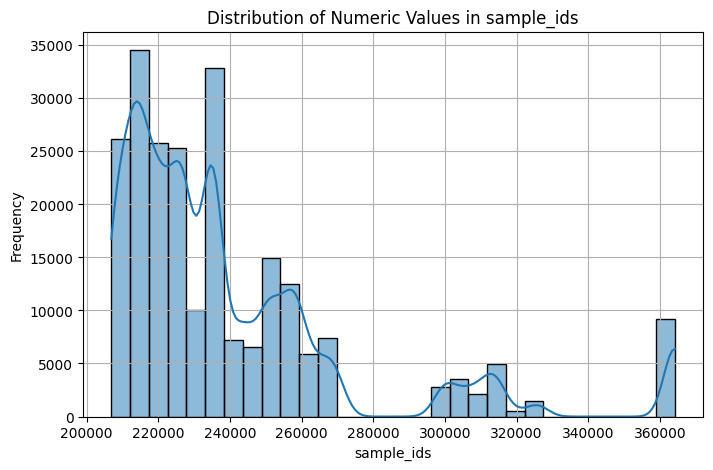

Processing column: elements


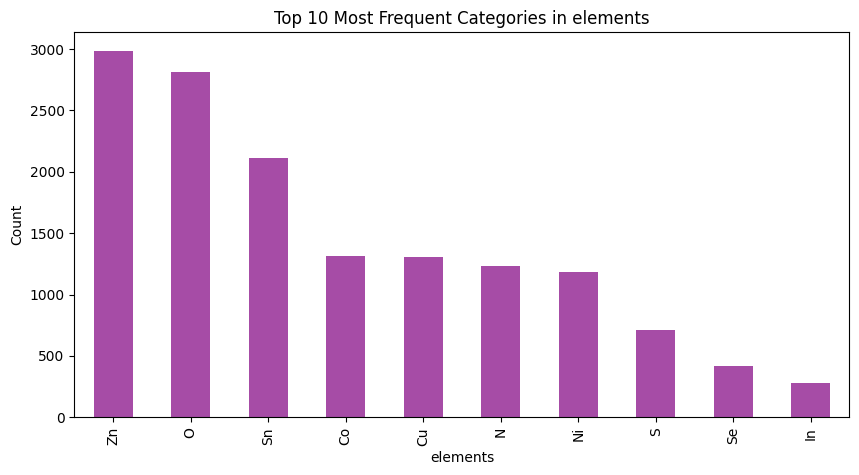

Processing column: xrf_elements


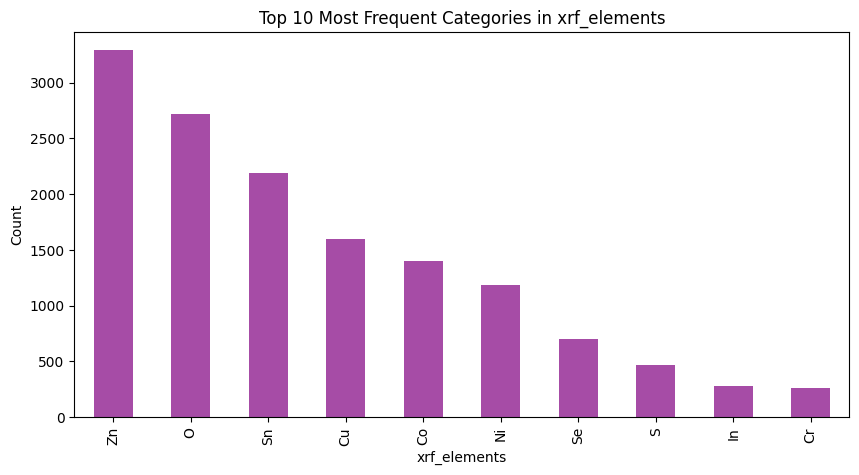

Processing column: xrf_compounds


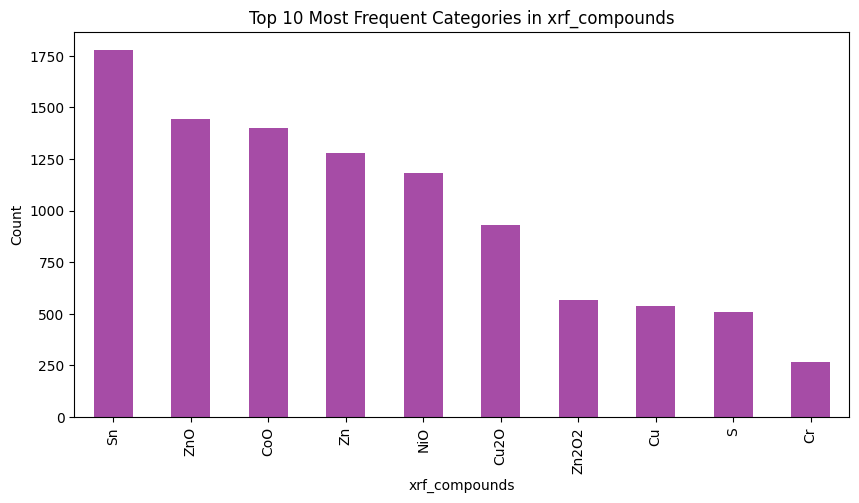

Processing column: deposition_compounds


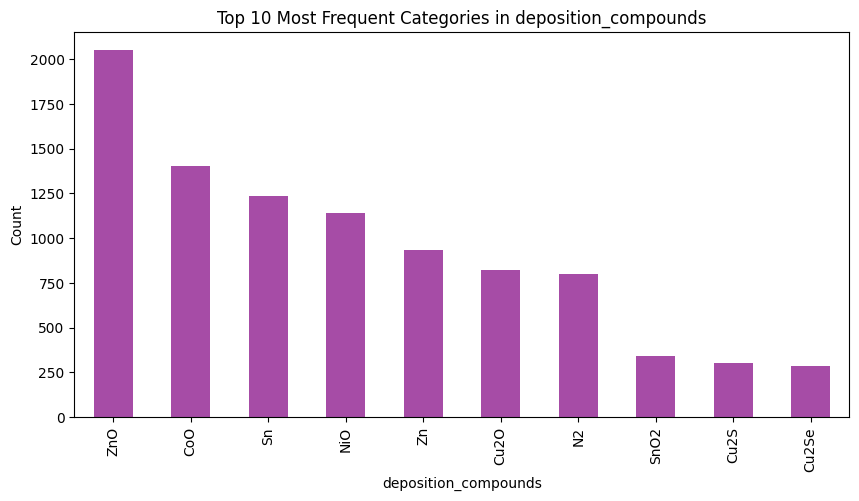

Processing column: deposition_power


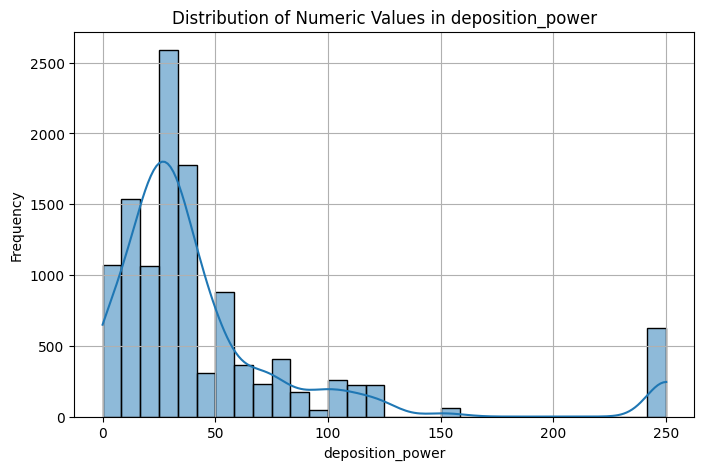

Processing column: deposition_target_pulses


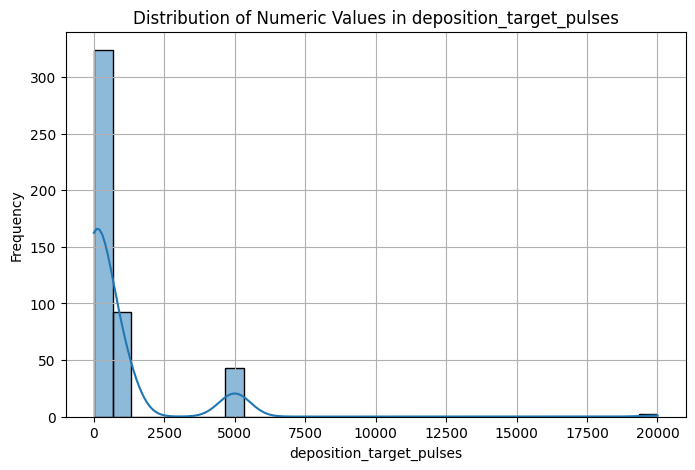

Processing column: deposition_rep_rate


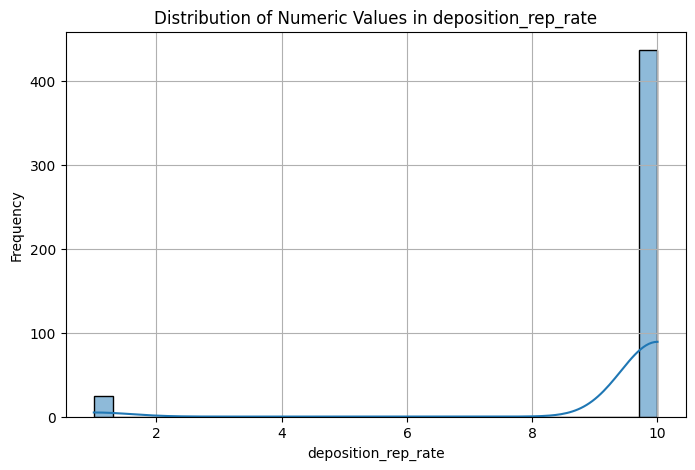

Processing column: deposition_gases


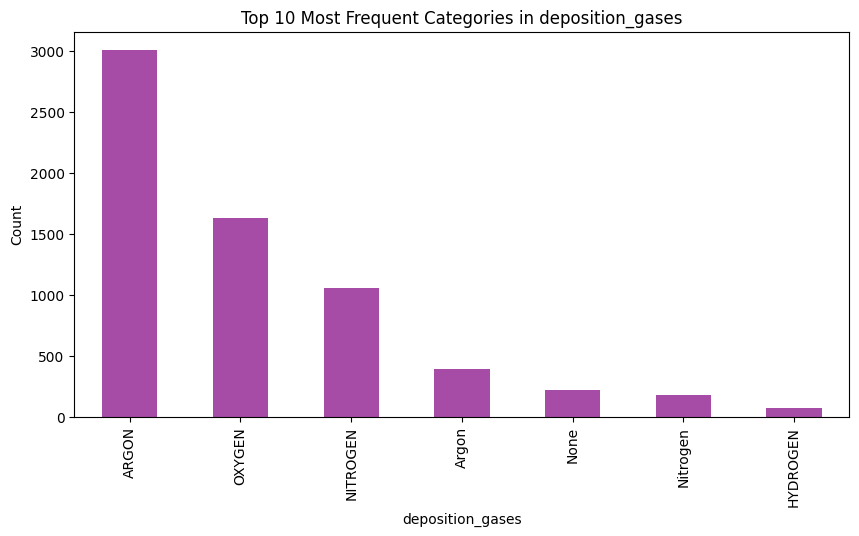

Processing column: deposition_gas_flow_sccm


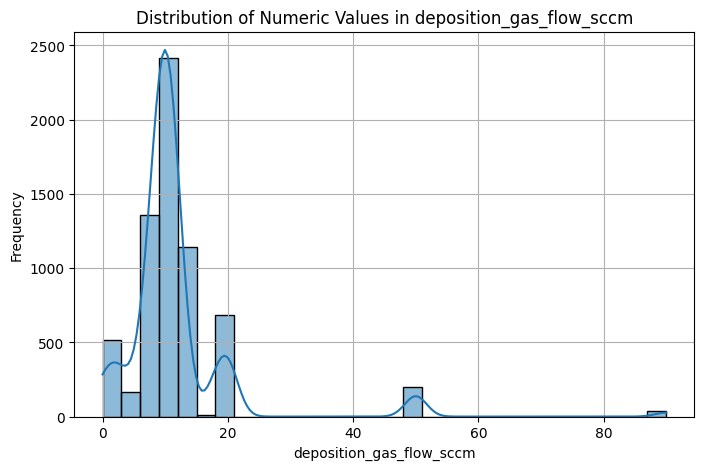

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# List of known nested columns from your dataset
nested_columns = [
    'sample_ids', 'elements', 'xrf_elements', 'xrf_compounds',
    'deposition_compounds', 'deposition_power', 'deposition_target_pulses',
    'deposition_rep_rate', 'deposition_gases', 'deposition_gas_flow_sccm'
]

# Function to flatten list-like columns
def flatten_list_col(column):
    values = []
    for entry in valid_data[column].dropna():
        if isinstance(entry, (list, np.ndarray)):
            values.extend([x for x in entry if x is not None and not (isinstance(x, float) and np.isnan(x))])
    return pd.Series(values)

# Process and plot each nested column
for col in nested_columns:
    if col in valid_data.columns:
        print(f"Processing column: {col}")

        # Flatten the column
        flat_series = flatten_list_col(col)
        
        # Check if the values are numeric or categorical
        if pd.api.types.is_numeric_dtype(flat_series):
            plt.figure(figsize=(8, 5))
            sns.histplot(flat_series, bins=30, kde=True)
            plt.title(f"Distribution of Numeric Values in {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.show()
        else:
            plt.figure(figsize=(10, 5))
            flat_series.value_counts().head(10).plot(kind='bar', color='purple', alpha=0.7)
            plt.title(f"Top 10 Most Frequent Categories in {col}")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.xticks(rotation=90)
            plt.show()


# How can we deal with composition data?

In [7]:
valid_data['xrf_compounds']

0       [Sn2O4, Cu2O]
1       [Sn2O4, Cu2O]
2       [Sn2O4, Cu2O]
3       [Sn2O4, Cu2O]
4       [Sn2O4, Cu2O]
            ...      
5151    [Cu2O, Ge2O4]
5152    [Cu2O, Ge2O4]
5153    [Cu2O, Ge2O4]
5154    [Cu2O, Ge2O4]
5155    [Cu2O, Ge2O4]
Name: xrf_compounds, Length: 5156, dtype: object

# Intro to materials project - source of simulated data

## What can we do with simulated data?

### 1) Data augmentation
### 2) pretrain algorithms off of simulated data
### 3) help with the missing data problem
### 4) can add in data during training
### 5) calibrate the computational to the experimental
### 6) calibrate the experimental to the computational

## Example chat GPT Prompt:


can you write code to loop through valid_data and for each list of xrf_compounds, go to materials project and download the structure information for the top 5 most stable phases with the exact composition for the phases loaded, and save the following into a database for each phase:

                            "Formula": entry.composition.reduced_formula,
                            "Material ID": material_id,
                            "Structure": conventional_structure,
                            "Energy (eV)": entry.energy,
                            "Energy per Atom (eV)": entry.energy_per_atom,
                            "Formation Energy per Atom (eV)": phase_diagram.get_form_energy_per_atom(entry),
                            "Concentrations": {el: entry.composition.get_atomic_fraction(el) for el in elements},
                            "XRD Pattern (2θ)": xrd_pattern.x.tolist(),
                            "XRD Pattern (Intensity)": xrd_pattern.y.tolist(),
                            "Top d-Spacings": top_d_spacings,
                            "Band Gap (eV)": band_gap

as well as the electronic structure total DOS data, and simulated X-ray diffraction pattern data with a shape factor of 1, a gaussian peak profile, and a scherrer crystallite size of 100 nm

In [10]:
comment this line and execute cell to install pymatgen
%pip install --upgrade pymatgen

SyntaxError: invalid syntax (3221744458.py, line 1)

In [12]:
API_KEY = "XXX"  # Replace with your Materials Project API key

`Chat GPT prompt`: write a snippet of code to download structures from materials project with the composition Sn2O4, or the same stoichiometry


In [13]:
from pymatgen.ext.matproj import MPRester
import time

def fetch_structures_by_formula(formula, retries=3, delay=5):
    """
    Fetch structures from Materials Project for a given formula.

    Parameters:
        formula (str): The chemical formula to search for (e.g., "Sn2O4").
        retries (int): Number of retries for failed requests.
        delay (int): Delay in seconds between retries.

    Returns:
        list: A list of dictionaries containing data for each structure.
    """
    results = []

    for attempt in range(retries):
        try:
            with MPRester(API_KEY) as mpr:
                # Search directly by formula
                materials = mpr.summary.search(formula=formula)

                if not materials:
                    print(f"No entries found for formula: {formula}")
                    return []

                # Fetch detailed information for each material
                for material in materials:
                    material_id = material["material_id"]
                    structure = mpr.get_structure_by_material_id(material_id)

                    results.append({
                        "Material ID": material_id,
                        "Formula": material["formula_pretty"],
                        "Structure": structure,
                        "Band Gap (eV)": material.get("band_gap"),
                        "Energy (eV)": material.get("energy"),
                        "Energy per Atom (eV)": material.get("energy_per_atom"),
                        "Formation Energy per Atom (eV)": material.get("formation_energy_per_atom"),
                    })
                return results
        except Exception as e:
            print(f"Error fetching data for {formula}: {e}")
            if attempt < retries - 1:
                time.sleep(delay * (2 ** attempt))  # Exponential backoff
            else:
                return []

# Example usage
formula = "Sn2O4"
structures = fetch_structures_by_formula(formula)

# Display the fetched data
for structure in structures:
    print(f"Material ID: {structure['Material ID']}, Formula: {structure['Formula']}, Band Gap: {structure['Band Gap (eV)']}")


  materials = mpr.summary.search(formula=formula)


Retrieving SummaryDoc documents:   0%|          | 0/30 [00:00<?, ?it/s]

Error fetching data for Sn2O4: 'MPDataDoc' object is not subscriptable


Retrieving SummaryDoc documents:   0%|          | 0/30 [00:00<?, ?it/s]

Error fetching data for Sn2O4: 'MPDataDoc' object is not subscriptable


Retrieving SummaryDoc documents:   0%|          | 0/30 [00:00<?, ?it/s]

Error fetching data for Sn2O4: 'MPDataDoc' object is not subscriptable


In [14]:
from mp_api.client import MPRester

with MPRester(API_KEY) as mpr:
    dos = mpr.get_dos_by_material_id("mp-149")
    bs_sc = mpr.get_bandstructure_by_material_id("mp-149")

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
dos.get_gap()

np.float64(0.6517510597230807)

In [16]:
dos.get_dos_fp()

DosFingerprint(energies=array([[-1.30797847e+01, -1.29640710e+01, -1.28483574e+01,
        -1.27326437e+01, -1.26169300e+01, -1.25012164e+01,
        -1.23855027e+01, -1.22697890e+01, -1.21540753e+01,
        -1.20383617e+01, -1.19226480e+01, -1.18069343e+01,
        -1.16912207e+01, -1.15755070e+01, -1.14597933e+01,
        -1.13440796e+01, -1.12283660e+01, -1.11126523e+01,
        -1.09969386e+01, -1.08812249e+01, -1.07655113e+01,
        -1.06497976e+01, -1.05340839e+01, -1.04183703e+01,
        -1.03026566e+01, -1.01869429e+01, -1.00712292e+01,
        -9.95551557e+00, -9.83980190e+00, -9.72408823e+00,
        -9.60837456e+00, -9.49266089e+00, -9.37694721e+00,
        -9.26123354e+00, -9.14551987e+00, -9.02980620e+00,
        -8.91409253e+00, -8.79837885e+00, -8.68266518e+00,
        -8.56695151e+00, -8.45123784e+00, -8.33552417e+00,
        -8.21981050e+00, -8.10409682e+00, -7.98838315e+00,
        -7.87266948e+00, -7.75695581e+00, -7.64124214e+00,
        -7.52552846e+00, -7.4098

In [17]:
bs_sc.get_direct_band_gap()

np.float64(2.5563000000000002)

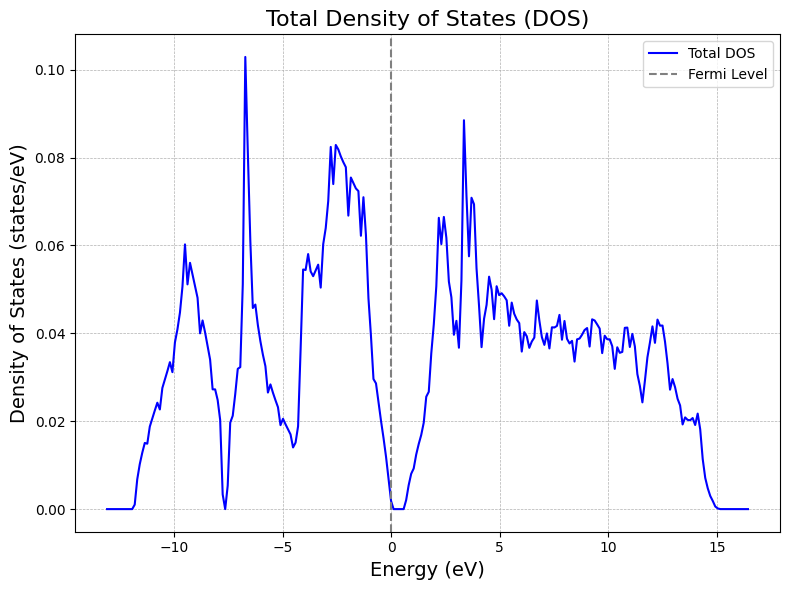

In [18]:
import matplotlib.pyplot as plt

# Assuming `dos_fp` is the result of `dos.get_dos_fp()`
energies = dos.get_dos_fp().energies.flatten()
densities = dos.get_dos_fp().densities

# Plot the total DOS
plt.figure(figsize=(8, 6))
plt.plot(energies, densities, label="Total DOS", color="blue")

# Add plot details
plt.axvline(0, color="gray", linestyle="--", label="Fermi Level")
plt.xlabel("Energy (eV)", fontsize=14)
plt.ylabel("Density of States (states/eV)", fontsize=14)
plt.title("Total Density of States (DOS)", fontsize=16)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [19]:
with MPRester(API_KEY) as mpr:
    # Search for materials by formula
    materials = mpr.materials.search(formula=formula)

Retrieving MaterialsDoc documents:   0%|          | 0/30 [00:00<?, ?it/s]

In [20]:
material=materials[0]

In [21]:
temp_dict=material.dict()

In [22]:
for key in temp_dict.keys():
    print(key, temp_dict[key])

builder_meta {'emmet_version': '0.84.3rc4', 'pymatgen_version': '2024.11.13', 'run_id': 'ccba9c49-e919-43c2-8d4f-35b2d60eb94b', 'batch_id': None, 'database_version': '2025.02.12.post', 'build_date': '2024-11-21 22:35:37.109000', 'license': 'BY-C'}
nsites 102
elements ['O', 'Sn']
nelements 2
composition {'Sn': 34.0, 'O': 68.0}
composition_reduced {'Sn': 1.0, 'O': 2.0}
formula_pretty SnO2
formula_anonymous AB2
chemsys O-Sn
volume 1454.1515162222058
density 5.851361985193295
density_atomic 14.256387413943195
symmetry {'crystal_system': 'Triclinic', 'symbol': 'P1', 'number': 1, 'point_group': '1', 'symprec': 0.1, 'angle_tolerance': 5.0, 'version': '2.5.0'}
material_id mp-1244894
structure {'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[11.81309216, -0.08216146, 0.02193751], [-0.10052967, 10.30193796, 0.41784012], [0.03467729, 0.40201719, 11.96607748]], 'pbc': [True, True, True], 'a': 11.813398246927418, 'b': 10.31089823013111, 'c': 11.9728

In [23]:
temp_dict['entries']['GGA']['energy']


-597.04490455

In [24]:
len(temp_dict['structure']['sites'])

102

In [25]:
material.entries.GGA.energy

-597.04490455

In [26]:
comment this line and execute to install nglview, ***THEN RESTART JUPYTER NOTEBOOK***
%pip install nodejs
%pip install jupyter_contrib_nbextensions
%pip install nglview


SyntaxError: invalid syntax (408768103.py, line 1)

In [27]:
import nglview as nv
view = nv.demo()
view

NGLWidget()

In [28]:
from mp_api.client import MPRester
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import numpy as np
import matplotlib.pyplot as plt
import time

# Parameters for XRD simulation
XRD_CALCULATOR = XRDCalculator(wavelength="CuKa")

def fetch_structures_and_data(formula, retries=3, delay=5):
    """
    Fetch structures, simulated XRD patterns, and DOS data from Materials Project.

    Parameters:
        formula (str): The chemical formula to search for (e.g., "SnO2").
        retries (int): Number of retries for failed requests.
        delay (int): Delay in seconds between retries.

    Returns:
        list: A list of dictionaries containing data for each structure.
    """
    results = []

    for attempt in range(retries):
        try:
            with MPRester(API_KEY) as mpr:
                # Search for materials by formula
                materials = mpr.materials.search(formula=formula)

                if not materials:
                    print(f"No entries found for formula: {formula}")
                    return []

                for material in materials:
                    material_id = material.material_id

                    # Fetch structure data
                    try:
                        structure = mpr.materials.get_structure_by_material_id(material_id)
                    except Exception as structure_error:
                        print(f"Error fetching structure for {material_id}: {structure_error}")
                        continue

                    # Simulate XRD pattern
                    xrd_pattern = XRD_CALCULATOR.get_pattern(
                        structure, two_theta_range=(0, 90)
                    )

                    # Fetch DOS and band structure
                    try:
                        dos = mpr.get_dos_by_material_id(material_id)
                        bs = mpr.get_bandstructure_by_material_id(material_id)
                        dos_data = dos.get_dos_fp() if dos else None
                        direct_gap = bs.get_direct_band_gap() if bs else None
                        indirect_gap = dos.get_gap() if dos else None
                    except Exception as data_error:
                        print(f"Error fetching DOS or band structure for {material_id}: {data_error}")
                        dos_data = None
                        direct_gap = None
                        indirect_gap = None

                    # Collect data
                    results.append({
                        "Material ID": material_id,
                        "Formula": material.formula_pretty,
                        "Structure": structure,
                        "Band Gap (eV)": material.band_gap if hasattr(material, "band_gap") else None,
                        "Direct Gap (eV)": direct_gap,
                        "Indirect Gap (eV)": indirect_gap,
                        "Energy (eV)": material.entries.GGA.energy if hasattr(material.entries, "GGA") else None,
                        "Formation Energy per Atom (eV)": material.entries.GGA.energy/len(material.structure.sites) if hasattr(material.entries, "GGA") else None,
                        "XRD Pattern (2θ)": xrd_pattern.x.tolist(),
                        "XRD Pattern (Intensity)": xrd_pattern.y.tolist(),
                        "Top d-Spacings": [
                            1 / (2 * np.sin(np.radians(theta / 2))) for theta in xrd_pattern.x
                        ],
                        "DOS Data": dos_data,  # Store DOS data
                    })

                return results
        except Exception as e:
            print(f"Error fetching data for {formula}: {e}")
            if attempt < retries - 1:
                time.sleep(delay * (2 ** attempt))  # Exponential backoff
            else:
                return []

# Example usage
formula = "SnO2"
structures = fetch_structures_and_data(formula)

# Display the fetched data
for structure in structures:
    print(f"Material ID: {structure['Material ID']}, Formula: {structure['Formula']}")
    print(f"Band Gap: {structure['Band Gap (eV)']}")
    print(f"Direct Gap: {structure['Direct Gap (eV)']}, Indirect Gap: {structure['Indirect Gap (eV)']}")
    print(f"Formation Energy per Atom: {structure['Formation Energy per Atom (eV)']}")
    print(f"XRD 2θ: {structure['XRD Pattern (2θ)'][:5]}")  # Display first 5 angles
    print(f"XRD Intensity: {structure['XRD Pattern (Intensity)'][:5]}")  # Display first 5 intensities
    print(f"Top d-Spacings: {structure['Top d-Spacings'][:5]}")  # Display first 5 d-spacings
    print(f"DOS Data Available: {structure['DOS Data'] is not None}\n")


Retrieving MaterialsDoc documents:   0%|          | 0/30 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1244894: No density of states data found for mp-1244894


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1244935: No density of states data found for mp-1244935


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1244941: No density of states data found for mp-1244941


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245027: No density of states data found for mp-1245027


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245116: No density of states data found for mp-1245116


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245126: No density of states data found for mp-1245126


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245178: No density of states data found for mp-1245178


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245203: No density of states data found for mp-1245203


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245282: No density of states data found for mp-1245282


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1356217: No density of states data found for mp-1356217


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1359814: No density of states data found for mp-1359814


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1041984: No setyawan_curtarolo band structure data found for mp-1041984


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1392145: No setyawan_curtarolo band structure data found for mp-1392145


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1401382: No setyawan_curtarolo band structure data found for mp-1401382


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-560417: No density of states data found for mp-560417


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1374892: No density of states data found for mp-1374892


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1352191: No setyawan_curtarolo band structure data found for mp-1352191


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1384340: No setyawan_curtarolo band structure data found for mp-1384340
Material ID: mp-1244894, Formula: SnO2
Band Gap: None
Direct Gap: None, Indirect Gap: None
Formation Energy per Atom: -5.8533814171568626
XRD 2θ: [7.403990115559638, 7.4845062479617805, 8.600606985950536, 10.504841965957, 10.565754485987545]
XRD Intensity: [37.97707932860134, 10.08057485458142, 14.85256318023984, 13.837934196799544, 19.507708636424464]
Top d-Spacings: [np.float64(7.743887227787728), np.float64(7.660697341403682), np.float64(6.668088403870145), np.float64(5.461872579647968), np.float64(5.430472908255584)]
DOS Data Available: False

Material ID: mp-1244935, Formula: SnO2
Band Gap: None
Direct Gap: None, Indirect Gap: None
Formation Energy per Atom: -5.950950907666667
XRD 2θ: [7.894949280987287, 8.110294725736676, 8.25342814588114, 10.884887706986445, 11.250784960093412]
XRD Intensity: [25.1678286397176, 18.820850086523564, 8.160150827758939, 0.1019426693398

In [5]:
### Plot a frontier of variability for XRD and DOS

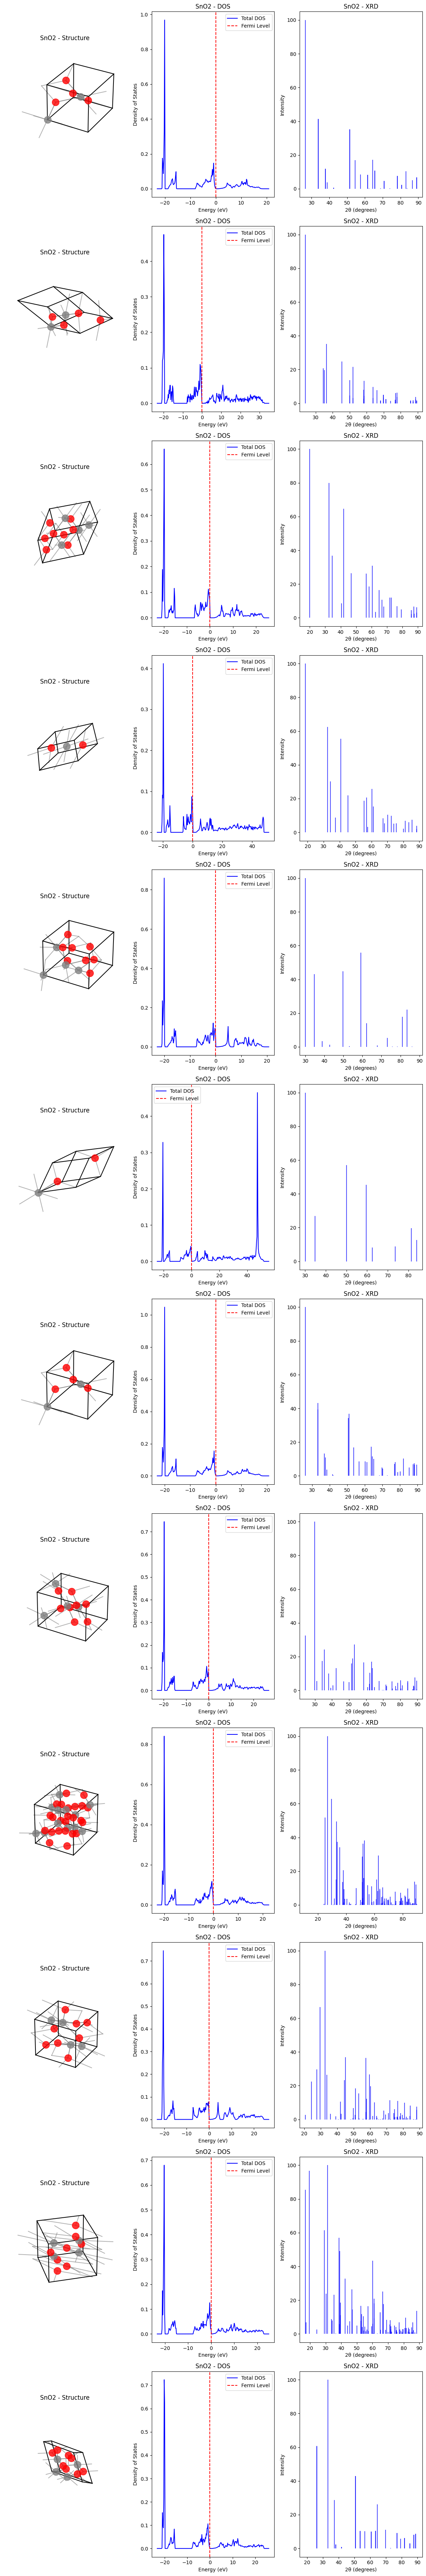

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from pymatgen.core import Structure

# Define a dictionary for conventional atom colors
ATOM_COLORS = {
    "H": "white", "He": "cyan", "Li": "purple", "Be": "darkgreen", "B": "salmon",
    "C": "black", "N": "blue", "O": "red", "F": "green", "Ne": "cyan",
    "Na": "purple", "Mg": "darkgreen", "Al": "gray", "Si": "brown", "P": "orange",
    "S": "yellow", "Cl": "green", "Ar": "cyan", "K": "purple", "Ca": "darkgreen",
    "Sc": "gray", "Ti": "silver", "V": "blue", "Cr": "green", "Mn": "purple",
    "Fe": "brown", "Co": "pink", "Ni": "blue", "Cu": "orange", "Zn": "gray",
    "Ga": "orange", "Ge": "gray", "As": "cyan", "Se": "yellow", "Br": "brown",
    "Kr": "cyan", "Rb": "purple", "Sr": "darkgreen", "Y": "gray", "Zr": "silver",
    "Nb": "blue", "Mo": "gray", "Tc": "green", "Ru": "gray", "Rh": "silver",
    "Pd": "silver", "Ag": "silver", "Cd": "gray", "In": "salmon", "Sn": "gray",
    "Sb": "orange", "Te": "brown", "I": "purple", "Xe": "cyan", "Cs": "purple",
    "Ba": "darkgreen", "La": "gray", "Ce": "gray", "Pr": "green", "Nd": "green",
    "Pm": "green", "Sm": "green", "Eu": "green", "Gd": "green", "Tb": "green",
    "Dy": "green", "Ho": "green", "Er": "green", "Tm": "green", "Yb": "green",
    "Lu": "gray", "Hf": "silver", "Ta": "blue", "W": "gray", "Re": "gray",
    "Os": "gray", "Ir": "silver", "Pt": "silver", "Au": "gold", "Hg": "silver",
    "Tl": "gray", "Pb": "gray", "Bi": "pink"
}

def plot_structures_dos_xrd(filtered_phases):
    num_phases = len(filtered_phases)
    fig = plt.figure(figsize=(12, 6 * num_phases))

    for i, phase in enumerate(filtered_phases):
        structure = phase["Structure"]

        # 3D structure plot
        ax_structure = fig.add_subplot(num_phases, 3, 3 * i + 1, projection='3d')
        for site in structure.sites:
            atom_type = str(site.specie)
            coords = site.coords
            color = ATOM_COLORS.get(atom_type, "gray")
            ax_structure.scatter(*coords, color=color, s=200, alpha=0.8)

            for neighbor in structure.get_neighbors(site, 2.5):
                start = site.coords
                end = neighbor[0].coords
                ax_structure.plot(*zip(start, end), color="gray", alpha=0.6)

        lattice = structure.lattice
        vertices = lattice.get_cartesian_coords([
            [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
            [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]
        ])
        edges = [
            (0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4),
            (0, 4), (1, 5), (2, 6), (3, 7)
        ]
        for start, end in edges:
            ax_structure.plot(*zip(vertices[start], vertices[end]), color="black")

        ax_structure.set_title(f"{phase['Formula']} - Structure")
        ax_structure.set_xticks([])
        ax_structure.set_yticks([])
        ax_structure.set_zticks([])
        ax_structure.set_axis_off()

        # 2D DOS plot
        ax_dos = fig.add_subplot(num_phases, 3, 3 * i + 2)
        dos = phase["DOS Data"]
        if dos is not None:
            ax_dos.plot(dos.energies.flatten(), dos.densities, label='Total DOS', color='blue')
            ax_dos.axvline(0, color='red', linestyle='--', label="Fermi Level")
            ax_dos.set_title(f"{phase['Formula']} - DOS")
            ax_dos.set_xlabel("Energy (eV)")
            ax_dos.set_ylabel("Density of States")
            ax_dos.legend()

        # 2D XRD pattern plot
        ax_xrd = fig.add_subplot(num_phases, 3, 3 * i + 3)
        xrd_2theta = phase["XRD Pattern (2θ)"]
        xrd_intensity = phase["XRD Pattern (Intensity)"]
        ax_xrd.vlines(xrd_2theta, 0, xrd_intensity, colors="blue", alpha=0.7)
        ax_xrd.set_title(f"{phase['Formula']} - XRD")
        ax_xrd.set_xlabel("2θ (degrees)")
        ax_xrd.set_ylabel("Intensity")

    plt.tight_layout()
    plt.show()

# Main function to process and plot
def main():
    # Assume `structures` is the output of `fetch_structures_and_data`
    filtered_phases = [
        phase for phase in structures
        if phase["DOS Data"] is not None and phase["Structure"] is not None and phase["XRD Pattern (2θ)"]
    ]

    if filtered_phases:
        plot_structures_dos_xrd(filtered_phases)
    else:
        print("No phases contain all required datasets (DOS, structure, and diffraction data).")

if __name__ == "__main__":
    main()


write python code to take the DOS and XRD patterns for each of the filtered_phases that are the output and convert them to a scaled and standard format arrays where the intensities are binned with 500 points on the x-axis:

In [30]:
import numpy as np

def process_dos_and_xrd(filtered_phases, num_bins=500):
    """
    Process DOS and XRD patterns into scaled and binned formats, filling in zero intensity for empty XRD bins.

    Parameters:
        filtered_phases (list): List of filtered phases containing DOS and XRD data.
        num_bins (int): Number of bins for scaling the x-axis (default: 500).

    Returns:
        list: List of dictionaries containing scaled and binned DOS and XRD data for each phase.
    """
    processed_data = []

    for phase in filtered_phases:
        phase_data = {"Material ID": phase["Material ID"], "Formula": phase["Formula"]}

        # Process DOS data
        if phase["DOS Data"] is not None:
            dos = phase["DOS Data"]
            dos_energies = dos.energies.flatten()
            dos_densities = dos.densities

            #dos_x = np.linspace(dos_energies.min(), dos_energies.max(), num_bins)
            dos_x = np.linspace(-10, 10, num_bins)
            dos_y = np.interp(dos_x, dos_energies, dos_densities)
            dos_y = (dos_y - dos_y.min()) / (dos_y.max() - dos_y.min())
            
            phase_data["Binned DOS"] = {"Energies": dos_x, "Densities": dos_y}

        # Process XRD data
        if "XRD Pattern (2θ)" in phase and "XRD Pattern (Intensity)" in phase:
            xrd_2theta = np.array(phase["XRD Pattern (2θ)"])
            xrd_intensity = np.array(phase["XRD Pattern (Intensity)"])

            xrd_x = np.linspace(xrd_2theta.min(), xrd_2theta.max(), num_bins)
            xrd_y = np.zeros_like(xrd_x)

            # Bin the XRD intensities
            for i in range(len(xrd_2theta)):
                bin_index = np.searchsorted(xrd_x, xrd_2theta[i]) - 1
                if 0 <= bin_index < len(xrd_x):
                    xrd_y[bin_index] += xrd_intensity[i]
                    
            xrd_y = (xrd_y - xrd_y.min()) / (xrd_y.max() - xrd_y.min())
            
            phase_data["Binned XRD"] = {"2θ": xrd_x, "Intensity": xrd_y}

        processed_data.append(phase_data)

    return processed_data


def main():
    # Assume `filtered_phases` is the output of `fetch_structures_and_data` with required datasets
    filtered_phases = [
        phase for phase in structures
        if phase["DOS Data"] is not None and phase["Structure"] is not None and phase.get("XRD Pattern (2θ)") is not None
    ]

    if filtered_phases:
        processed_data = process_dos_and_xrd(filtered_phases)

        for data in processed_data:
            print(f"Material ID: {data['Material ID']}, Formula: {data['Formula']}")
            if "Binned DOS" in data:
                print(f"DOS Energies (first 5): {data['Binned DOS']['Energies'][:5]}")
                print(f"DOS Densities (first 5): {data['Binned DOS']['Densities'][:5]}")
            if "Binned XRD" in data:
                print(f"XRD 2θ (first 5): {data['Binned XRD']['2θ'][:5]}")
                print(f"XRD Intensities (first 5): {data['Binned XRD']['Intensity'][:5]}")
            print("\n")
    else:
        print("No phases contain all required datasets (DOS, structure, and diffraction data).")

if __name__ == "__main__":
    main()


Material ID: mp-856, Formula: SnO2
DOS Energies (first 5): [-10.          -9.95991984  -9.91983968  -9.87975952  -9.83967936]
DOS Densities (first 5): [0. 0. 0. 0. 0.]
XRD 2θ (first 5): [26.45423027 26.5799531  26.70567594 26.83139877 26.9571216 ]
XRD Intensities (first 5): [0. 0. 0. 0. 0.]


Material ID: mp-755071, Formula: SnO2
DOS Energies (first 5): [-10.          -9.95991984  -9.91983968  -9.87975952  -9.83967936]
DOS Densities (first 5): [0. 0. 0. 0. 0.]
XRD 2θ (first 5): [23.87990679 24.01139684 24.1428869  24.27437696 24.40586702]
XRD Intensities (first 5): [0. 0. 0. 0. 0.]


Material ID: mp-1044721, Formula: SnO2
DOS Energies (first 5): [-10.          -9.95991984  -9.91983968  -9.87975952  -9.83967936]
DOS Densities (first 5): [0. 0. 0. 0. 0.]
XRD 2θ (first 5): [17.0860551  17.2309167  17.37577829 17.52063988 17.66550148]
XRD Intensities (first 5): [0. 0. 0. 0. 0.]


Material ID: mp-1390618, Formula: SnO2
DOS Energies (first 5): [-10.          -9.95991984  -9.91983968  -9.8797

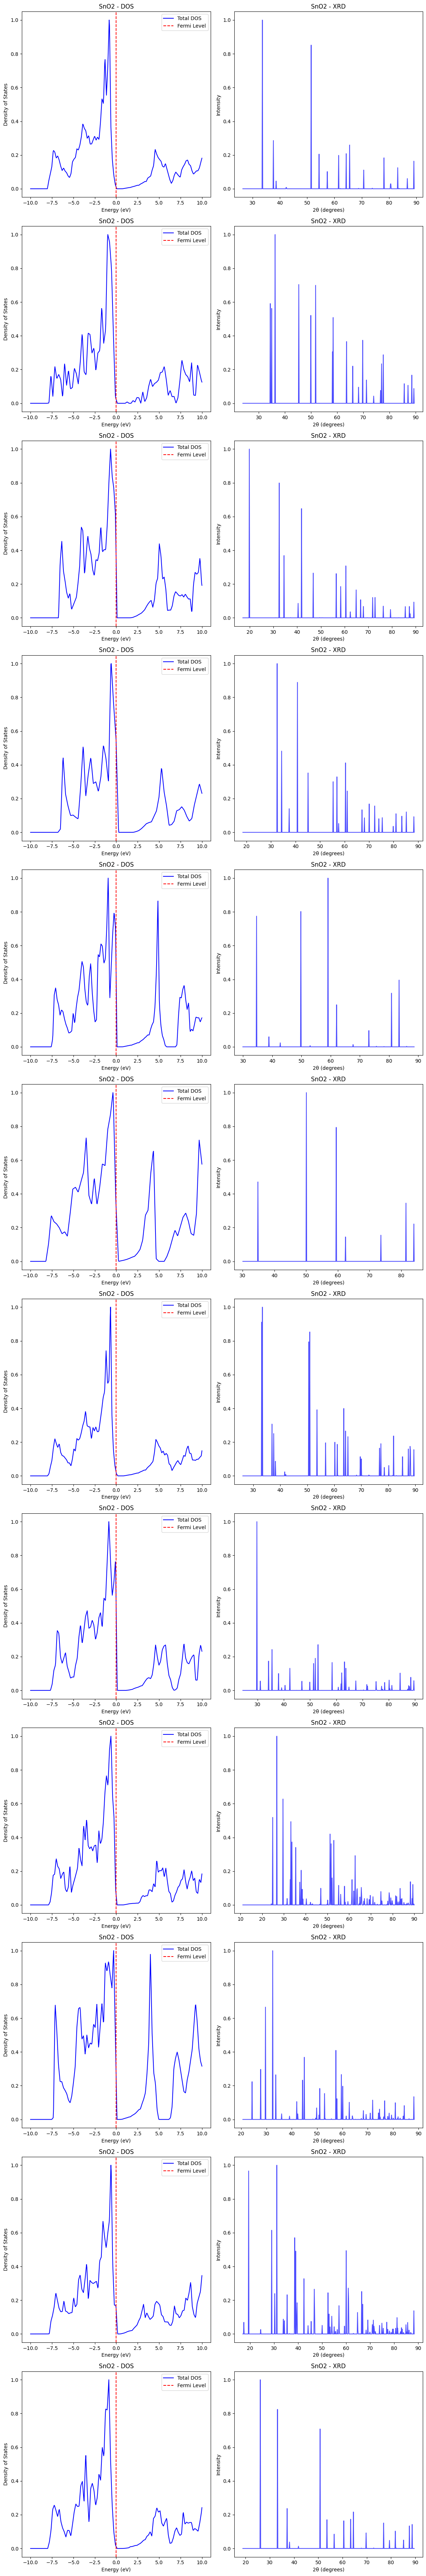

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_binned_results(processed_data):
    """
    Plot the binned DOS and XRD data.

    Parameters:
        processed_data (list): List of dictionaries containing binned DOS and XRD data.
    """
    num_phases = len(processed_data)
    fig, axs = plt.subplots(num_phases, 2, figsize=(12, 6 * num_phases))

    if num_phases == 1:
        axs = np.array([axs])  # Ensure consistent indexing for single row

    for i, data in enumerate(processed_data):
        # Plot DOS
        if "Binned DOS" in data:
            dos = data["Binned DOS"]
            ax_dos = axs[i, 0]
            ax_dos.plot(dos["Energies"], dos["Densities"], color="blue", label="Total DOS")
            ax_dos.axvline(0, color="red", linestyle="--", label="Fermi Level")
            ax_dos.set_title(f"{data['Formula']} - DOS")
            ax_dos.set_xlabel("Energy (eV)")
            ax_dos.set_ylabel("Density of States")
            ax_dos.legend()

        # Plot XRD
        if "Binned XRD" in data:
            xrd = data["Binned XRD"]
            ax_xrd = axs[i, 1]
            ax_xrd.plot(xrd["2θ"], xrd["Intensity"], color="blue", alpha=0.7)
            ax_xrd.set_title(f"{data['Formula']} - XRD")
            ax_xrd.set_xlabel("2θ (degrees)")
            ax_xrd.set_ylabel("Intensity")

    plt.tight_layout()
    plt.show()


def main():
    # Assume `filtered_phases` is the output of `fetch_structures_and_data` with required datasets
    filtered_phases = [
        phase for phase in structures
        if phase["DOS Data"] is not None and phase["Structure"] is not None and phase.get("XRD Pattern (2θ)") is not None
    ]

    if filtered_phases:
        processed_data = process_dos_and_xrd(filtered_phases)

        plot_binned_results(processed_data)
    else:
        print("No phases contain all required datasets (DOS, structure, and diffraction data).")


if __name__ == "__main__":
    main()


In [32]:
import pandas as pd

# File path
input_file = "Filtered_Libraries_Data_wTauc_interpolated_opt_and_xrd_dspacing.parquet"

# Read the parquet file
try:
    loaded_data = pd.read_parquet(input_file, engine='pyarrow')
    print("File successfully loaded!")
    print(loaded_data.head())  # Display the first few rows for verification
except FileNotFoundError:
    print(f"File {input_file} not found. Please ensure the file exists.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")


File successfully loaded!
       id  num pdac  quality  person_id               sample_date  \
0  212251   34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
1  212253   34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
2  212252   34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
3  212255   34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
4  212254   34    4      3.0       52.0  2013-03-05T00:00:00.000Z   

          owner_name               owner_email xrf_type sputter_operator  ...  \
0  Lauryn Baranowski  l.l.baranowski@gmail.com    maxxi             None  ...   
1  Lauryn Baranowski  l.l.baranowski@gmail.com    maxxi             None  ...   
2  Lauryn Baranowski  l.l.baranowski@gmail.com    maxxi             None  ...   
3  Lauryn Baranowski  l.l.baranowski@gmail.com    maxxi             None  ...   
4  Lauryn Baranowski  l.l.baranowski@gmail.com    maxxi             None  ...   

                        opt_normalized_transmittance  \
0  [0.0003538, 0

In [33]:
valid_data=loaded_data

In [34]:
valid_data['xrf_compounds']

0       [Sn2O4, Cu2O]
1       [Sn2O4, Cu2O]
2       [Sn2O4, Cu2O]
3       [Sn2O4, Cu2O]
4       [Sn2O4, Cu2O]
            ...      
5151    [Cu2O, Ge2O4]
5152    [Cu2O, Ge2O4]
5153    [Cu2O, Ge2O4]
5154    [Cu2O, Ge2O4]
5155    [Cu2O, Ge2O4]
Name: xrf_compounds, Length: 5156, dtype: object

In [35]:
valid_data = valid_data[valid_data['xrf_compounds'].notna()].reset_index(drop=True)

In [40]:

#comment this line and execute to download all of the material structure information from Materials Project for all compounds from HTEM data
from mp_api.client import MPRester
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import numpy as np
import time

# Initialize the XRD calculator
XRD_CALCULATOR = XRDCalculator(wavelength="CuKa")

def extract_unique_compounds(valid_data):
    """
    Extract a unique list of compounds from valid_data['xrf_compounds'].

    Parameters:
        valid_data (DataFrame): Data containing xrf_compounds column.

    Returns:
        list: List of unique compound formulas.
    """
    compound_set = set()
    for compounds in valid_data['xrf_compounds']:
        compound_set.update(compounds)
    return list(compound_set)

def fetch_structures_and_data(formula, num_results=20, retries=3, delay=5):
    """
    Fetch structures, simulated XRD patterns, and DOS data from Materials Project.

    Parameters:
        formula (str): The chemical formula to search for.
        num_results (int): Number of top stable results to fetch (default: 20).
        retries (int): Number of retries for failed requests.
        delay (int): Delay in seconds between retries.

    Returns:
        list: A list of dictionaries containing data for each structure.
    """
    results = []

    for attempt in range(retries):
        try:
            with MPRester(API_KEY) as mpr:
                # Search for materials by formula
                materials = mpr.materials.search(formula=formula)
                if not materials:
                    print(f"No entries found for formula: {formula}")
                    return []

                # Sort by formation energy and fetch top entries
                materials_sorted = sorted(materials, key=lambda x: x.entries.GGA.energy/len(x.structure.sites))[:num_results]

                for material in materials_sorted:
                    material_id = material.material_id

                    # Fetch structure data
                    try:
                        structure = mpr.materials.get_structure_by_material_id(material_id)
                    except Exception as structure_error:
                        print(f"Error fetching structure for {material_id}: {structure_error}")
                        continue

                    # Simulate XRD pattern
                    xrd_pattern = XRD_CALCULATOR.get_pattern(structure, two_theta_range=(0, 90))

                    # Fetch DOS and band structure
                    try:
                        dos = mpr.get_dos_by_material_id(material_id)
                        bs = mpr.get_bandstructure_by_material_id(material_id)
                        dos_data = dos.get_dos_fp() if dos else None
                        direct_gap = bs.get_direct_band_gap() if bs else None
                        indirect_gap = dos.get_gap() if dos else None
                    except Exception as data_error:
                        print(f"Error fetching DOS or band structure for {material_id}: {data_error}")
                        dos_data = None
                        direct_gap = None
                        indirect_gap = None

                    # Collect raw data
                    results.append({
                        "Material ID": material_id,
                        "Formula": material.formula_pretty,
                        "Structure": structure,
                        "Direct Gap (eV)": direct_gap,
                        "Indirect Gap (eV)": indirect_gap,
                        "Formation Energy per Atom (eV)": material.entries.GGA.energy/len(material.structure.sites) if hasattr(material.entries, "GGA") else None,
                        "XRD Pattern (2θ)": xrd_pattern.x.tolist(),
                        "XRD Pattern (Intensity)": xrd_pattern.y.tolist(),
                        "DOS Data": dos_data,
                    })

                return results
        except Exception as e:
            print(f"Error fetching data for {formula}: {e}")
            if attempt < retries - 1:
                time.sleep(delay * (2 ** attempt))  # Exponential backoff
            else:
                return []

def process_and_combine_data(raw_data, num_bins=500):
    """
    Process DOS and XRD patterns and combine them with raw data.

    Parameters:
        raw_data (list): List of raw data dictionaries.
        num_bins (int): Number of bins for scaling the x-axis (default: 500).

    Returns:
        list: List of dictionaries with raw and processed data combined.
    """
    for phase in raw_data:
        phase_data = {"Material ID": phase["Material ID"], "Formula": phase["Formula"]}

        
        # Process DOS data
        if phase["DOS Data"] is not None:
            dos = phase["DOS Data"]
            dos_energies = dos.energies.flatten()
            dos_densities = dos.densities

            #dos_x = np.linspace(dos_energies.min(), dos_energies.max(), num_bins)
            dos_x = np.linspace(-10, 10, num_bins)
            dos_y = np.interp(dos_x, dos_energies, dos_densities)
            dos_y = (dos_y - dos_y.min()) / (dos_y.max() - dos_y.min())
            
            phase["Binned DOS"] = {"Energies": dos_x, "Densities": dos_y}

        # Process XRD data
        if "XRD Pattern (2θ)" in phase and "XRD Pattern (Intensity)" in phase:
            xrd_2theta = np.array(phase["XRD Pattern (2θ)"])
            xrd_intensity = np.array(phase["XRD Pattern (Intensity)"])

            xrd_x = np.linspace(xrd_2theta.min(), xrd_2theta.max(), num_bins)
            xrd_y = np.zeros_like(xrd_x)

            # Bin the XRD intensities
            for i in range(len(xrd_2theta)):
                bin_index = np.searchsorted(xrd_x, xrd_2theta[i]) - 1
                if 0 <= bin_index < len(xrd_x):
                    xrd_y[bin_index] += xrd_intensity[i]
                    
            xrd_y = (xrd_y - xrd_y.min()) / (xrd_y.max() - xrd_y.min())
            phase["Binned XRD"] = {"2θ": xrd_x, "Intensity": xrd_y}
    return raw_data

def main(valid_data):
    unique_compounds = extract_unique_compounds(valid_data)

    all_data = {}
    for compound in unique_compounds:
        print(f"Processing compound: {compound}")
        raw_data = fetch_structures_and_data(compound)
        if raw_data:
            combined_data = process_and_combine_data(raw_data)
            all_data[compound] = combined_data

    return all_data

if __name__ == "__main__":
    # Replace `valid_data` with your actual DataFrame containing 'xrf_compounds'
    all_data = main(valid_data)
    print(f"All data collected for compounds: {list(all_data.keys())}")


Processing compound: S


Retrieving MaterialsDoc documents:   0%|          | 0/32 [00:00<?, ?it/s]

Error fetching data for S: 'NoneType' object has no attribute 'energy'


Retrieving MaterialsDoc documents:   0%|          | 0/32 [00:00<?, ?it/s]

Error fetching data for S: 'NoneType' object has no attribute 'energy'


Retrieving MaterialsDoc documents:   0%|          | 0/32 [00:00<?, ?it/s]

Error fetching data for S: 'NoneType' object has no attribute 'energy'
Processing compound: Cu2Se


Retrieving MaterialsDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1097707: No density of states data found for mp-1097707


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1021499: No setyawan_curtarolo band structure data found for mp-1021499


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1225805: x=np.float64(7.358783608195904e-05) is out of range of provided x_values (0.0003, 0.0114)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-684525: No setyawan_curtarolo band structure data found for mp-684525


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-16366: x=np.float64(8.787853073463269e-05) is out of range of provided x_values (0.0122, 0.0302)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-22297: x=np.float64(0.00011347636181909046) is out of range of provided x_values (0.0334, 0.4321)
Processing compound: NiO


Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Error fetching data for NiO: 'NoneType' object has no attribute 'energy'


Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Error fetching data for NiO: 'NoneType' object has no attribute 'energy'


Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Error fetching data for NiO: 'NoneType' object has no attribute 'energy'
Processing compound: Ca


Retrieving MaterialsDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-45: x=np.float64(4.6584102948525735e-05) is out of range of provided x_values (1.5371, 1.6521)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1183484: x=np.float64(0.00016911581209395305) is out of range of provided x_values (4.2823, 5.3583)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1064227: x=np.float64(0.00017176228385807097) is out of range of provided x_values (1.3174, 1.9599)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1078638: x=np.float64(0.0002798783308345827) is out of range of provided x_values (7.895, 8.2962)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-166: x=np.float64(4.949312843578211e-05) is out of range of provided x_values (0.9136, 0.9765)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-21: x=np.float64(4.782180409795103e-05) is out of range of provided x_values (1.68, 1.7095)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1008498: x=np.float64(0.0001703588555722139) is out of range of provided x_values (4.0864, 4.6243)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1067285: x=np.float64(0.00017097561719140432) is out of range of provided x_values (4.3037, 4.6069)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-10683: x=np.float64(4.999284857571214e-05) is out of range of provided x_values (0.9685, 0.9841)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1227541: No density of states data found for mp-1227541


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-132: x=np.float64(7.03964067966017e-05) is out of range of provided x_values (1.802, 1.886)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1183455: x=np.float64(9.126994502748626e-05) is out of range of provided x_values (1.7129, 1.7132)
Processing compound: Ge2O4


Retrieving MaterialsDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1190549: No density of states data found for mp-1190549


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Processing compound: Cu2O


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Processing compound: Ga


Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-142: x=np.float64(0.00026436181909045476) is out of range of provided x_values (0.6048, 0.636)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1067880: x=np.float64(0.0002338892703648176) is out of range of provided x_values (0.4088, 0.4245)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-569423: x=np.float64(0.0003582178860569716) is out of range of provided x_values (2.5233, 2.5995)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-567540: x=np.float64(0.001209306771614193) is out of range of provided x_values (6.653, 6.6871)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-10021: x=np.float64(0.00011248343328335832) is out of range of provided x_values (0.7949, 0.798)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1007857: x=np.float64(0.00021530154422788605) is out of range of provided x_values (1.5133, 1.5303)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-140: x=np.float64(5.465750624687656e-05) is out of range of provided x_values (0.3928, 0.3994)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-569007: x=np.float64(0.0013625723888055971) is out of range of provided x_values (7.4387, 7.7427)
Processing compound: Sn3N4


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Processing compound: Se


Retrieving MaterialsDoc documents:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-570481: No density of states data found for mp-570481


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1247808: No density of states data found for mp-1247808


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1009757: No density of states data found for mp-1009757


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-7755: x=np.float64(4.4424737631184405e-05) is out of range of provided x_values (0.5422, 0.543)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-12771: x=np.float64(9.555302348825588e-05) is out of range of provided x_values (1.9127, 1.9351)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-119: x=np.float64(4.585861569215392e-05) is out of range of provided x_values (0.7722, 0.7797)
Processing compound: Ti


Retrieving MaterialsDoc documents:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-72: x=np.float64(0.000115106091954023) is out of range of provided x_values (2.2542, 2.408)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-46: x=np.float64(7.538504747626187e-05) is out of range of provided x_values (1.7, 1.8263)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-6985: x=np.float64(6.76372863568216e-05) is out of range of provided x_values (1.7525, 1.882)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-73: x=np.float64(4.409493253373313e-05) is out of range of provided x_values (1.9725, 2.1742)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245164: No density of states data found for mp-1245164


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245006: No density of states data found for mp-1245006


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245320: No density of states data found for mp-1245320


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245170: No density of states data found for mp-1245170


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1244924: No density of states data found for mp-1244924


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1238818: No density of states data found for mp-1238818
Processing compound: Zn


Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-79: x=np.float64(0.00011456033983008494) is out of range of provided x_values (0.4241, 0.4353)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-2646972: No density of states data found for mp-2646972


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1187812: x=np.float64(0.0001686908795602199) is out of range of provided x_values (0.5472, 0.5488)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245184: No density of states data found for mp-1245184


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245266: No density of states data found for mp-1245266


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245093: No density of states data found for mp-1245093


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1244987: No density of states data found for mp-1244987


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-2647117: No density of states data found for mp-2647117
Processing compound: InS


Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Processing compound: Ba


Retrieving MaterialsDoc documents:   0%|          | 0/11 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1096840: x=np.float64(0.00017165571214392802) is out of range of provided x_values (2.5355, 2.5887)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-10679: x=np.float64(6.300606696651676e-05) is out of range of provided x_values (1.674, 1.8155)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-56: x=np.float64(0.00010526662668665666) is out of range of provided x_values (3.0722, 3.4671)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1058581: x=np.float64(0.0002307667216391804) is out of range of provided x_values (2.5929, 2.9607)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-570384: x=np.float64(0.00017821014492753622) is out of range of provided x_values (3.2781, 4.3865)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-605790: x=np.float64(0.00016089037481259368) is out of range of provided x_values (0.7767, 0.8689)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1977763: No setyawan_curtarolo band structure data found for mp-1977763


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1096835: No density of states data found for mp-1096835


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1008283: x=np.float64(0.00018993924537731135) is out of range of provided x_values (3.5109, 3.6692)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-122: x=np.float64(6.819675662168917e-05) is out of range of provided x_values (1.1872, 1.2217)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Processing compound: InO


Retrieving MaterialsDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-2646987: No density of states data found for mp-2646987


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1184809: x=np.float64(0.0001796411944027986) is out of range of provided x_values (1.3468, 1.36)
Processing compound: Zn2O2


Retrieving MaterialsDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-997630: No density of states data found for mp-997630


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-2346983: No density of states data found for mp-2346983


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245209: No density of states data found for mp-1245209


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245109: No density of states data found for mp-1245109


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245015: No density of states data found for mp-1245015


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245255: No density of states data found for mp-1245255


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Processing compound: Sn


Retrieving MaterialsDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-117: x=np.float64(0.0001284643328335832) is out of range of provided x_values (0.0561, 0.0719)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-949028: No density of states data found for mp-949028


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-84: x=np.float64(0.000110968115942029) is out of range of provided x_values (0.9774, 0.9975)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1022725: x=np.float64(8.565539230384806e-05) is out of range of provided x_values (0.595, 0.6337)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-623511: x=np.float64(6.13672363818091e-05) is out of range of provided x_values (0.5435, 0.5438)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-55: x=np.float64(5.838225387306347e-05) is out of range of provided x_values (0.6193, 0.6451)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1056308: x=np.float64(0.0001189679860069965) is out of range of provided x_values (0.5592, 0.5632)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-7162: x=np.float64(6.183423288355821e-05) is out of range of provided x_values (0.5972, 0.5978)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1179414: No density of states data found for mp-1179414
Processing compound: Te


Retrieving MaterialsDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-567313: No setyawan_curtarolo band structure data found for mp-567313


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-570459: x=np.float64(0.00028040555222388805) is out of range of provided x_values (0.0652, 0.0823)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-105: x=np.float64(0.0003305073113443279) is out of range of provided x_values (2.3802, 2.4005)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1178952: x=np.float64(0.0002546331834082958) is out of range of provided x_values (2.5836, 2.6231)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1064307: x=np.float64(0.00025615761119440284) is out of range of provided x_values (1.978, 1.9943)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1178932: x=np.float64(0.00011542604197901051) is out of range of provided x_values (0.5859, 0.6337)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-9924: x=np.float64(0.00012403055972013994) is out of range of provided x_values (0.7484, 0.758)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-10654: x=np.float64(0.0001604271514242879) is out of range of provided x_values (0.5901, 0.6062)
Processing compound: Ta3N5


Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1205002: x=np.float64(0.0007272920289855073) is out of range of provided x_values (5.0777, 5.4059)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1204550: x=np.float64(0.0007298809095452275) is out of range of provided x_values (0.1074, 0.5112)
Processing compound: CoO


Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Error fetching data for CoO: 'NoneType' object has no attribute 'energy'


Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Error fetching data for CoO: 'NoneType' object has no attribute 'energy'


Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Error fetching data for CoO: 'NoneType' object has no attribute 'energy'
Processing compound: In2O3


Retrieving MaterialsDoc documents:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1194571: No setyawan_curtarolo band structure data found for mp-1194571


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-644741: No density of states data found for mp-644741


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1105699: No density of states data found for mp-1105699


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245022: No density of states data found for mp-1245022


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245202: No density of states data found for mp-1245202


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1244879: No density of states data found for mp-1244879
Processing compound: V2O5


Retrieving MaterialsDoc documents:   0%|          | 0/58 [00:00<?, ?it/s]

Error fetching data for V2O5: 'NoneType' object has no attribute 'energy'


Retrieving MaterialsDoc documents:   0%|          | 0/58 [00:00<?, ?it/s]

Error fetching data for V2O5: 'NoneType' object has no attribute 'energy'


Retrieving MaterialsDoc documents:   0%|          | 0/58 [00:00<?, ?it/s]

Error fetching data for V2O5: 'NoneType' object has no attribute 'energy'
Processing compound: SnO


Retrieving MaterialsDoc documents:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245076: No density of states data found for mp-1245076


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245329: No density of states data found for mp-1245329


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245115: No density of states data found for mp-1245115


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245133: No density of states data found for mp-1245133


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1065811: x=np.float64(0.00010872930034982508) is out of range of provided x_values (0.1642, 0.1762)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-999142: x=np.float64(0.00016824249375312346) is out of range of provided x_values (0.3383, 0.369)
Processing compound: Cu3N


Retrieving MaterialsDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1225758: x=np.float64(9.670078460769615e-05) is out of range of provided x_values (1.2358, 1.2956)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1225717: x=np.float64(0.00010259476761619191) is out of range of provided x_values (2.5496, 2.6569)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1225746: x=np.float64(0.00011718906546726637) is out of range of provided x_values (1.6452, 1.757)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1078576: x=np.float64(0.00015607388305847073) is out of range of provided x_values (2.084, 2.1976)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1203286: No density of states data found for mp-1203286


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-13480: x=np.float64(7.959575712143927e-05) is out of range of provided x_values (2.2609, 2.2822)
Processing compound: GaO


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1183990: x=np.float64(0.000161304047976012) is out of range of provided x_values (1.3624, 1.3707)
Processing compound: Se2O


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]

No entries found for formula: Se2O
Processing compound: Ag2O


Retrieving MaterialsDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-38238: x=np.float64(0.0003754790654672664) is out of range of provided x_values (1.5242, 2.9315)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-7711: x=np.float64(0.00011139206396801599) is out of range of provided x_values (2.1355, 2.1933)
Processing compound: ZnO


Retrieving MaterialsDoc documents:   0%|          | 0/12 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-997630: No density of states data found for mp-997630


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-2346983: No density of states data found for mp-2346983


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245209: No density of states data found for mp-1245209


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245109: No density of states data found for mp-1245109


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245015: No density of states data found for mp-1245015


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245255: No density of states data found for mp-1245255


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Processing compound: Sn2O4


Retrieving MaterialsDoc documents:   0%|          | 0/30 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1384340: No setyawan_curtarolo band structure data found for mp-1384340


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1374892: No density of states data found for mp-1374892


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-560417: No density of states data found for mp-560417


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1041984: No setyawan_curtarolo band structure data found for mp-1041984


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1401382: No setyawan_curtarolo band structure data found for mp-1401382


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1352191: No setyawan_curtarolo band structure data found for mp-1352191


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1359814: No density of states data found for mp-1359814


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245178: No density of states data found for mp-1245178


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245027: No density of states data found for mp-1245027
Processing compound: SnO2


Retrieving MaterialsDoc documents:   0%|          | 0/30 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1384340: No setyawan_curtarolo band structure data found for mp-1384340


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1374892: No density of states data found for mp-1374892


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-560417: No density of states data found for mp-560417


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1041984: No setyawan_curtarolo band structure data found for mp-1041984


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1401382: No setyawan_curtarolo band structure data found for mp-1401382


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1352191: No setyawan_curtarolo band structure data found for mp-1352191


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1359814: No density of states data found for mp-1359814


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245178: No density of states data found for mp-1245178


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1245027: No density of states data found for mp-1245027
Processing compound: Fe2O3


Retrieving MaterialsDoc documents:   0%|          | 0/26 [00:00<?, ?it/s]

Error fetching data for Fe2O3: 'NoneType' object has no attribute 'energy'


Retrieving MaterialsDoc documents:   0%|          | 0/26 [00:00<?, ?it/s]

Error fetching data for Fe2O3: 'NoneType' object has no attribute 'energy'


Retrieving MaterialsDoc documents:   0%|          | 0/26 [00:00<?, ?it/s]

Error fetching data for Fe2O3: 'NoneType' object has no attribute 'energy'
Processing compound: TaO


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1895: x=np.float64(4.7621264367816094e-05) is out of range of provided x_values (1.3741, 1.4306)
Processing compound: Sb2O3


Retrieving MaterialsDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1205345: No density of states data found for mp-1205345


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1202960: No setyawan_curtarolo band structure data found for mp-1202960


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1046803: No density of states data found for mp-1046803
Processing compound: In


Retrieving MaterialsDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1184502: x=np.float64(0.0002201177861069465) is out of range of provided x_values (1.5705, 1.5773)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1055994: x=np.float64(6.99672263868066e-05) is out of range of provided x_values (0.4189, 0.4212)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1184478: x=np.float64(0.00010902180409795105) is out of range of provided x_values (0.4836, 0.4906)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-85: x=np.float64(6.96650924537731e-05) is out of range of provided x_values (0.4401, 0.4443)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-973111: x=np.float64(0.00017249367316341828) is out of range of provided x_values (0.8885, 0.9045)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1184511: x=np.float64(0.0002697786956521739) is out of range of provided x_values (1.8354, 1.8608)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1184693: No setyawan_curtarolo band structure data found for mp-1184693
Processing compound: Cr


Retrieving MaterialsDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-90: x=np.float64(3.5638985507246386e-05) is out of range of provided x_values (0.6743, 0.7083)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-17: x=np.float64(0.00024019111444277866) is out of range of provided x_values (4.5629, 4.71)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1192789: No density of states data found for mp-1192789


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1059289: x=np.float64(5.80028935532234e-05) is out of range of provided x_values (2.82, 3.2173)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-8633: x=np.float64(5.3567121439280355e-05) is out of range of provided x_values (1.7823, 2.4321)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-89: x=np.float64(5.683091454272863e-05) is out of range of provided x_values (2.9865, 3.0943)
Processing compound: Sb


Retrieving MaterialsDoc documents:   0%|          | 0/14 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-104: x=np.float64(0.00010004778110944529) is out of range of provided x_values (0.0068, 0.01)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1179605: x=np.float64(0.00017935506246876564) is out of range of provided x_values (1.2148, 1.2183)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-133: x=np.float64(6.077783608195903e-05) is out of range of provided x_values (0.5203, 0.5207)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-632286: x=np.float64(0.00018165474262868568) is out of range of provided x_values (1.3266, 1.3274)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-567409: x=np.float64(0.0002699563168415792) is out of range of provided x_values (0.4019, 0.4404)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1179618: No setyawan_curtarolo band structure data found for mp-1179618


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-7761: x=np.float64(6.248307846076961e-05) is out of range of provided x_values (0.6306, 0.6308)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1236935: No density of states data found for mp-1236935


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-567144: x=np.float64(0.0001759609195402299) is out of range of provided x_values (2.5811, 2.5946)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-80: x=np.float64(9.885331334332833e-05) is out of range of provided x_values (1.5878, 1.8279)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-10631: x=np.float64(6.15044727636182e-05) is out of range of provided x_values (0.6781, 0.685)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-10630: x=np.float64(6.424119940029986e-05) is out of range of provided x_values (0.7147, 0.7177)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1179613: No setyawan_curtarolo band structure data found for mp-1179613


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1104795: No density of states data found for mp-1104795
Processing compound: SnS


Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Processing compound: Cu


Retrieving MaterialsDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-30: x=np.float64(2.6541794102948528e-05) is out of range of provided x_values (0.3007, 0.3054)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-989695: x=np.float64(0.00010577880059970016) is out of range of provided x_values (1.2669, 1.2777)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-989782: x=np.float64(6.96364167916042e-05) is out of range of provided x_values (0.6369, 0.6921)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1010136: x=np.float64(4.2280334832583706e-05) is out of range of provided x_values (0.3177, 0.3213)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-998890: x=np.float64(4.2179265367316334e-05) is out of range of provided x_values (0.3197, 0.3227)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1059259: x=np.float64(8.47397151424288e-05) is out of range of provided x_values (0.5538, 0.5593)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1120774: No density of states data found for mp-1120774


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1056079: x=np.float64(0.00010039823088455773) is out of range of provided x_values (0.2837, 3.4384)
Processing compound: Mn


Retrieving MaterialsDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-35: x=np.float64(0.0008828394852573713) is out of range of provided x_values (30.486600000000003, 35.137100000000004)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-2647025: No density of states data found for mp-2647025


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-542909: x=np.float64(0.0005992403298350824) is out of range of provided x_values (38.1046, 40.6985)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-8634: x=np.float64(4.868235382308846e-05) is out of range of provided x_values (1.3677, 1.6746)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1055908: x=np.float64(2.952503248375812e-05) is out of range of provided x_values (1.9981, 2.0157)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1057139: x=np.float64(9.311162418790604e-05) is out of range of provided x_values (2.7565999999999997, 2.7668999999999997)


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Error fetching DOS or band structure for mp-1191484: No density of states data found for mp-1191484
All data collected for compounds: ['Cu2Se', 'Ca', 'Ge2O4', 'Cu2O', 'Ga', 'Sn3N4', 'Se', 'Ti', 'Zn', 'InS', 'Ba', 'InO', 'Zn2O2', 'Sn', 'Te', 'Ta3N5', 'In2O3', 'SnO', 'Cu3N', 'GaO', 'Ag2O', 'ZnO', 'Sn2O4', 'SnO2', 'TaO', 'Sb2O3', 'In', 'Cr', 'Sb', 'SnS', 'Cu', 'Mn']


In [41]:
import pickle

# Filepath to save the pickle file
output_file = "all_MP_data_dict.pkl"

# Save all_data to the pickle file
with open(output_file, "wb") as f:
    pickle.dump(all_data, f)

print(f"All data has been successfully saved to {output_file}")


All data has been successfully saved to all_MP_data_dict.pkl


In [42]:
import pickle

# Filepath of the pickle file
input_file = "all_MP_data_dict.pkl"

# Load all_data from the pickle file
with open(input_file, "rb") as f:
    all_data = pickle.load(f)

print("All data has been successfully loaded from the pickle file.")


All data has been successfully loaded from the pickle file.


In [43]:
print({key: len(all_data[key]) for key in all_data.keys()})


{'Cu2Se': 7, 'Ca': 12, 'Ge2O4': 9, 'Cu2O': 1, 'Ga': 8, 'Sn3N4': 1, 'Se': 10, 'Ti': 10, 'Zn': 8, 'InS': 2, 'Ba': 11, 'InO': 2, 'Zn2O2': 12, 'Sn': 9, 'Te': 9, 'Ta3N5': 3, 'In2O3': 9, 'SnO': 10, 'Cu3N': 7, 'GaO': 1, 'Ag2O': 4, 'ZnO': 12, 'Sn2O4': 20, 'SnO2': 20, 'TaO': 1, 'Sb2O3': 6, 'In': 7, 'Cr': 6, 'Sb': 14, 'SnS': 8, 'Cu': 8, 'Mn': 7}


`ChatGPT prompt`: can you write a script to loop through all_data and make it uniform length. all_data is a dictionary, where each key in all data contains a list of dictionaries. I want to make it so that the list of dictionaries within each dictionary entry off all_data is exactly length 10. To do this, I want to truncate any list that is longer than 10 entries to the first 10, and if the list has fewer than 10 entries I want to replicate the existing entries until the list is longer than 10 entries, and then truncate it to the first 10 entires

In [44]:
for key in all_data.keys():
    # Get the current list of dictionaries
    current_list = all_data[key]
    
    if len(current_list) > 10:
        # Truncate the list to the first 10 dictionaries
        all_data[key] = current_list[:10]
    elif len(current_list) < 10:
        # Extend the list by repeating its contents until it has more than 10 entries
        repeated_list = current_list * (10 // len(current_list)) + current_list[:10 % len(current_list)]
        # Truncate to ensure exactly 10 entries
        all_data[key] = repeated_list[:10]
    else:
        # No changes needed if the list already has exactly 10 entries
        all_data[key] = current_list

print("Successfully updated all_data to ensure each list has exactly 10 dictionaries.")


Successfully updated all_data to ensure each list has exactly 10 dictionaries.


In [45]:
print({key: len(all_data[key]) for key in all_data.keys()})


{'Cu2Se': 10, 'Ca': 10, 'Ge2O4': 10, 'Cu2O': 10, 'Ga': 10, 'Sn3N4': 10, 'Se': 10, 'Ti': 10, 'Zn': 10, 'InS': 10, 'Ba': 10, 'InO': 10, 'Zn2O2': 10, 'Sn': 10, 'Te': 10, 'Ta3N5': 10, 'In2O3': 10, 'SnO': 10, 'Cu3N': 10, 'GaO': 10, 'Ag2O': 10, 'ZnO': 10, 'Sn2O4': 10, 'SnO2': 10, 'TaO': 10, 'Sb2O3': 10, 'In': 10, 'Cr': 10, 'Sb': 10, 'SnS': 10, 'Cu': 10, 'Mn': 10}


In [46]:
all_data['Cu'][0].keys()

dict_keys(['Material ID', 'Formula', 'Structure', 'Direct Gap (eV)', 'Indirect Gap (eV)', 'Formation Energy per Atom (eV)', 'XRD Pattern (2θ)', 'XRD Pattern (Intensity)', 'DOS Data', 'Binned XRD'])

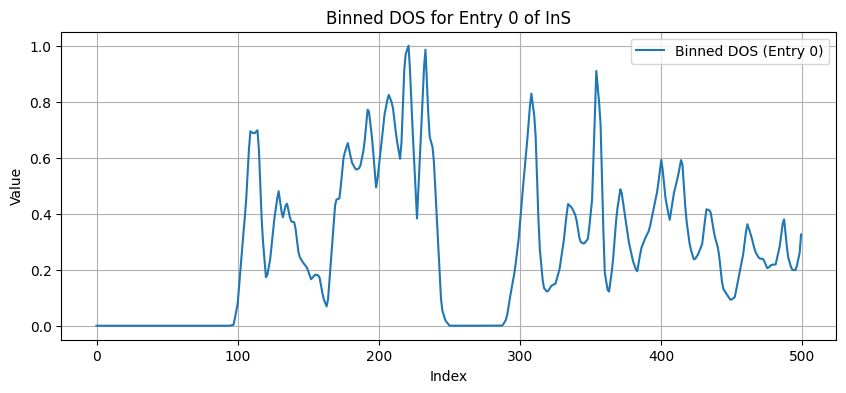

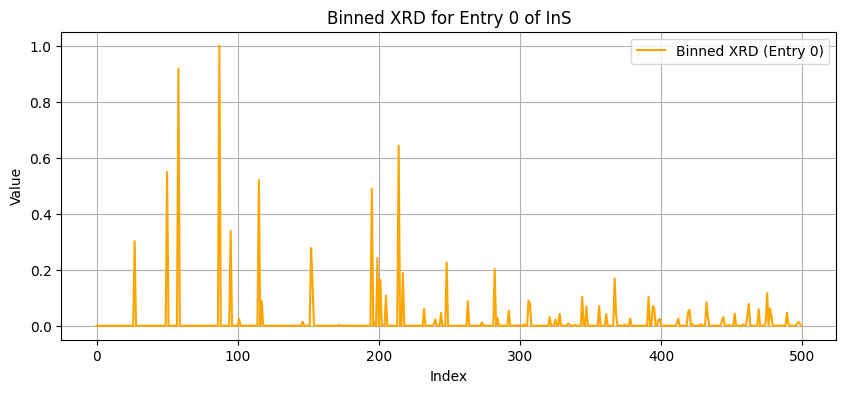

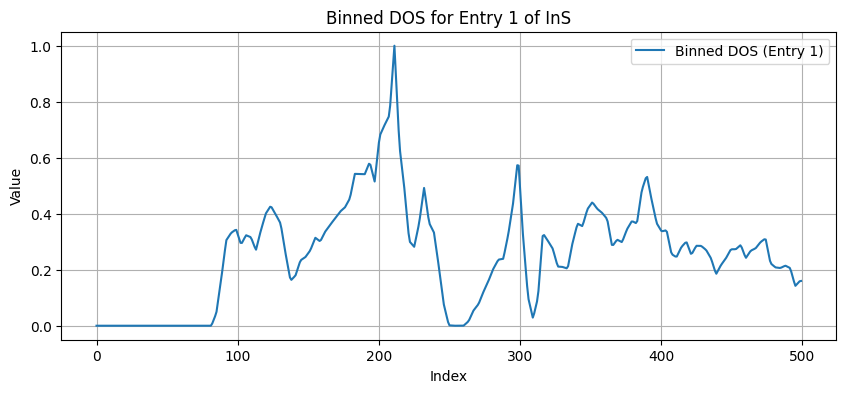

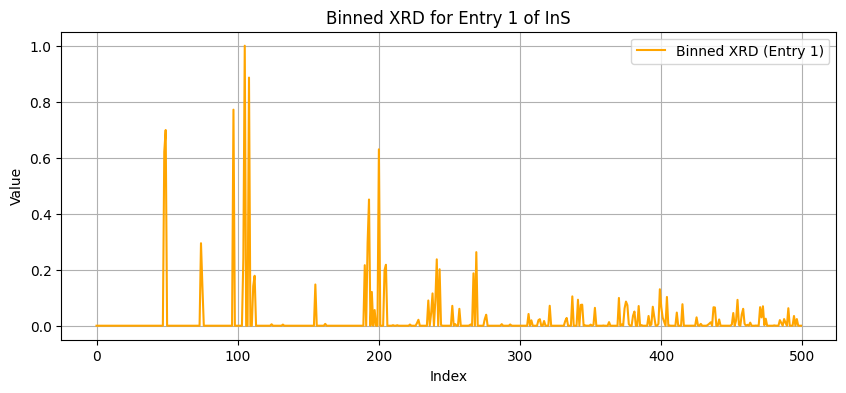

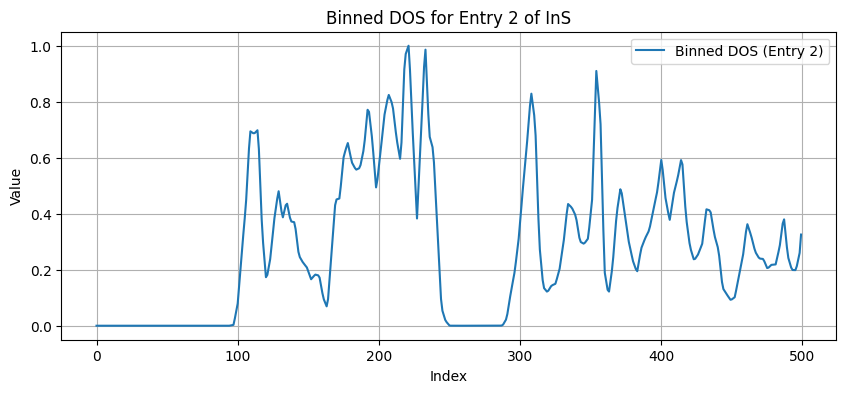

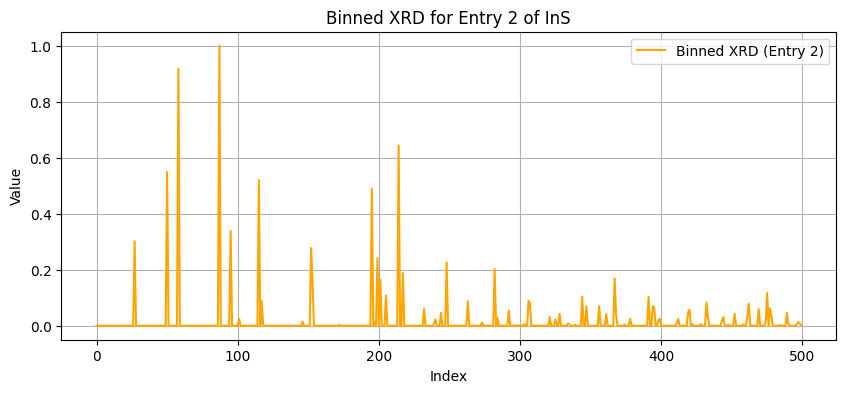

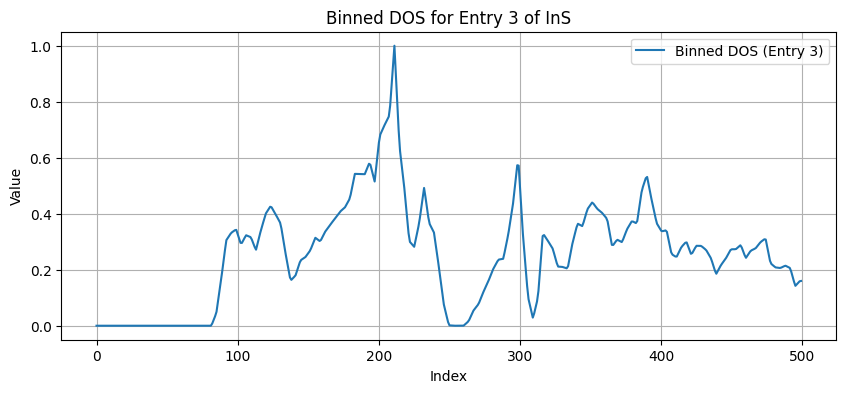

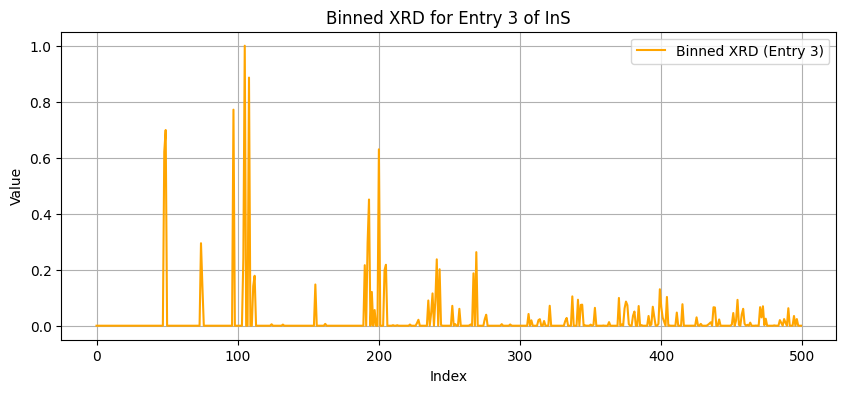

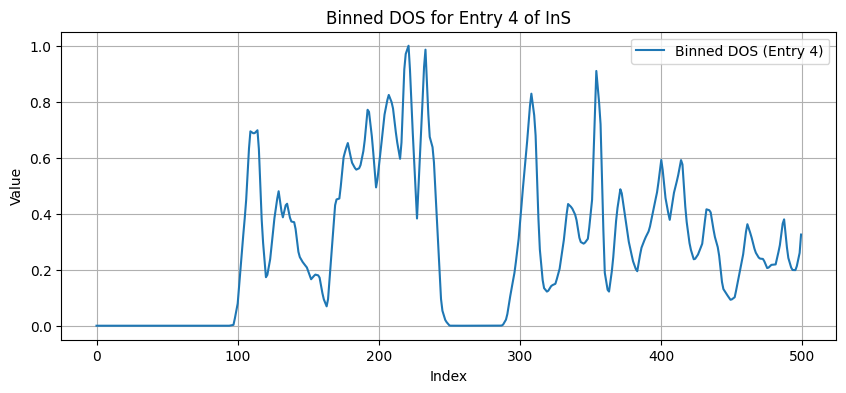

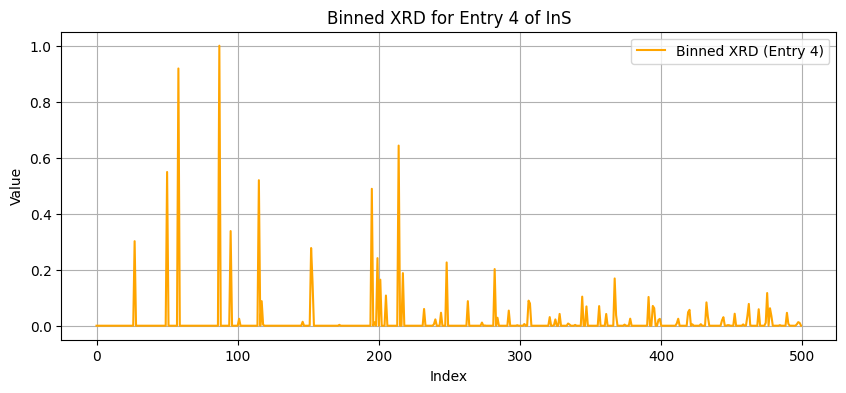

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def plot_raw_binned_data(compound, all_data, max_plots=5):
    """
    Plot raw Binned DOS and Binned XRD data for a given compound.

    Args:
        compound (str): The name of the compound.
        all_data (dict): The dataset containing compound features.
        max_plots (int): Maximum number of entries to plot.
    """
    if compound not in all_data:
        raise ValueError(f"Compound '{compound}' not found in all_data.")

    # Loop through the first few entries in the compound data
    for i, entry in enumerate(all_data[compound]):
        if i >= max_plots:
            break
        
        # Extract Binned DOS
        binned_dos = entry.get('Binned DOS', [])
        if isinstance(binned_dos, dict):
            binned_dos = np.array(binned_dos['Densities'], dtype=np.float32)
        elif isinstance(binned_dos, list):
            binned_dos = np.array(binned_dos, dtype=np.float32)
        else:
            binned_dos = np.zeros(500, dtype=np.float32)  # Default zeros
        
        # Extract Binned XRD
        binned_xrd = entry.get('Binned XRD', [])
        if isinstance(binned_xrd, dict):
            binned_xrd = np.array(binned_xrd['Intensity'], dtype=np.float32)
        elif isinstance(binned_xrd, list):
            binned_xrd = np.array(binned_xrd, dtype=np.float32)
        else:
            binned_xrd = np.zeros(500, dtype=np.float32)  # Default zeros

        # Plot Binned DOS
        plt.figure(figsize=(10, 4))
        plt.plot(binned_dos, label=f"Binned DOS (Entry {i})")
        plt.title(f"Binned DOS for Entry {i} of {compound}")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot Binned XRD
        plt.figure(figsize=(10, 4))
        plt.plot(binned_xrd, label=f"Binned XRD (Entry {i})", color='orange')
        plt.title(f"Binned XRD for Entry {i} of {compound}")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
compound_name = 'InS'  # Replace with the compound you want to visualize
plot_raw_binned_data(compound_name, all_data)


In [48]:
# Data Preparation
features = []
conductivities = []
dos_length=500
xrd_length=500
max_compounds=3

if not valid_data.empty:
    for _, row in valid_data.iterrows():
        compounds = row['xrf_compounds']
        concentrations = row['xrf_concentration']
        conductivity = row['fpm_conductivity']

        if conductivity > 0 and len(compounds) == len(concentrations):
            compound_matrices = []  # To store features for up to `max_compounds` compounds

            for compound, concentration in zip(compounds, concentrations):
                if compound in all_data:
                    compound_features = []

                    for entry in all_data[compound]:
                        # Extract scalar values
                        entry_features = [
                            entry.get('Direct Gap (eV)', 0.0),
                            entry.get('Indirect Gap (eV)', 0.0),
                            entry.get('Formation Energy per Atom (eV)', 0.0)
                        ]

                        # Extract Binned DOS
                        binned_dos = entry.get('Binned DOS', [])
                        if isinstance(binned_dos, dict):
                            binned_dos = np.array(binned_dos.get('Densities', []), dtype=np.float32)
                        elif isinstance(binned_dos, list):
                            binned_dos = np.array(binned_dos, dtype=np.float32)
                        else:
                            binned_dos = np.zeros(dos_length, dtype=np.float32)  # Default zeros

                        # Ensure consistent length for Binned DOS
                        if len(binned_dos) > dos_length:
                            binned_dos = binned_dos[:dos_length]
                        elif len(binned_dos) < dos_length:
                            binned_dos = np.pad(binned_dos, (0, dos_length - len(binned_dos)))

                        entry_features.extend(binned_dos)

                        # Extract Binned XRD
                        binned_xrd = entry.get('Binned XRD', [])
                        if isinstance(binned_xrd, dict):
                            binned_xrd = np.array(binned_xrd.get('Intensity', []), dtype=np.float32)
                        elif isinstance(binned_xrd, list):
                            binned_xrd = np.array(binned_xrd, dtype=np.float32)
                        else:
                            binned_xrd = np.zeros(xrd_length, dtype=np.float32)  # Default zeros

                        # Ensure consistent length for Binned XRD
                        if len(binned_xrd) > xrd_length:
                            binned_xrd = binned_xrd[:xrd_length]
                        elif len(binned_xrd) < xrd_length:
                            binned_xrd = np.pad(binned_xrd, (0, xrd_length - len(binned_xrd)))

                        entry_features.extend(binned_xrd)

                        # Scale by concentration
                        entry_features = np.array(entry_features, dtype=np.float32) * concentration

                        # Add features for this compound entry
                        compound_features.append(entry_features)

                    if compound_features:  # Only add to compound_matrices if valid features exist
                        compound_matrix = np.vstack(compound_features)
                        compound_matrices.append(compound_matrix)

            # Handle cases where no valid data exists
            if not compound_matrices:
                compound_matrices = [np.zeros((1, dos_length + xrd_length + 3), dtype=np.float32)]

            # Pad or truncate to ensure `max_compounds`
            while len(compound_matrices) < max_compounds:
                compound_matrices.append(np.zeros_like(compound_matrices[0]))

            if len(compound_matrices) > max_compounds:
                compound_matrices = compound_matrices[:max_compounds]

            # Combine into a single feature matrix
            aggregated_features = np.vstack(compound_matrices)

            # Append to features and labels
            features.append(aggregated_features)
            conductivities.append(np.log10(conductivity))

  log_features = np.log10(aggregated_features + 1e-8)


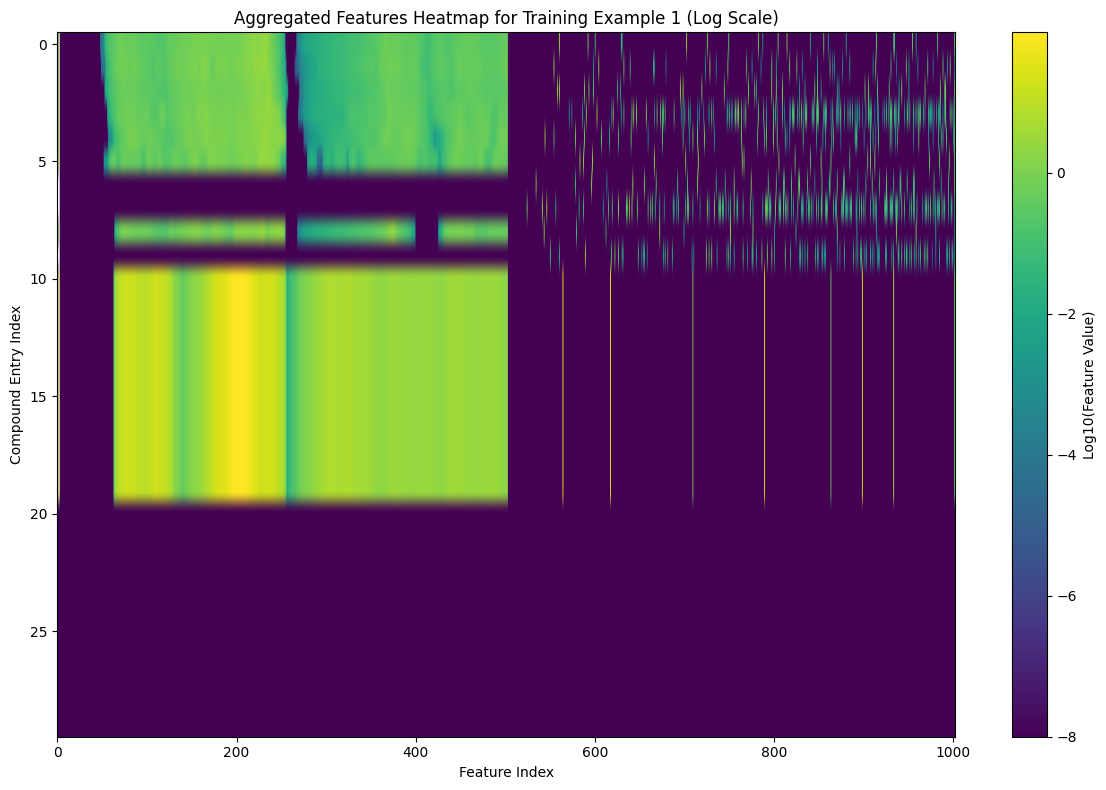

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_aggregated_features_log(aggregated_features, title="Aggregated Features Heatmap (Log Scale)"):
    """
    Visualize the 2D matrix of aggregated features as a heatmap on a logarithmic scale.

    Args:
        aggregated_features (np.ndarray): The 2D array to visualize.
        title (str): Title for the heatmap.
    """
    # Add a small positive offset to avoid log of zero
    log_features = np.log10(aggregated_features + 1e-8)

    plt.figure(figsize=(12, 8))
    plt.imshow(log_features, aspect='auto', cmap='viridis')
    plt.colorbar(label='Log10(Feature Value)')
    plt.xlabel('Feature Index')
    plt.ylabel('Compound Entry Index')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage
if features:  # Ensure there are valid features
    sample_index = 0  # Index of the training example to visualize
    if sample_index < len(features):
        aggregated_features_to_plot = features[sample_index]
        visualize_aggregated_features_log(
            aggregated_features_to_plot,
            title=f"Aggregated Features Heatmap for Training Example {sample_index + 1} (Log Scale)"
        )
    else:
        print(f"Sample index {sample_index} is out of range. There are {len(features)} features.")
else:
    print("No valid features to visualize.")


In [50]:
features[0].shape

(30, 1003)

In [51]:
aggregated_features[3:100]

array([[ 3.39099794e+01,  3.60440540e+01, -3.17315269e+02, ...,
         0.00000000e+00,  2.21985501e-01,  0.00000000e+00],
       [ 3.39099794e+01,  3.60440540e+01, -3.17315269e+02, ...,
         0.00000000e+00,  2.21985501e-01,  0.00000000e+00],
       [ 3.39099794e+01,  3.60440540e+01, -3.17315269e+02, ...,
         0.00000000e+00,  2.21985501e-01,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Epoch [10/200], Train Loss: 0.3144, Val Loss: 0.3312
Epoch [20/200], Train Loss: 0.2753, Val Loss: 0.2937
Epoch [30/200], Train Loss: 0.2569, Val Loss: 0.2777
Epoch [40/200], Train Loss: 0.2450, Val Loss: 0.2632
Epoch [50/200], Train Loss: 0.2351, Val Loss: 0.2543
Epoch [60/200], Train Loss: 0.2287, Val Loss: 0.2490
Epoch [70/200], Train Loss: 0.2274, Val Loss: 0.2448
Epoch [80/200], Train Loss: 0.2250, Val Loss: 0.2515
Epoch [90/200], Train Loss: 0.2215, Val Loss: 0.2490
Epoch [100/200], Train Loss: 0.2197, Val Loss: 0.2515
Epoch [110/200], Train Loss: 0.2045, Val Loss: 0.2358
Epoch [120/200], Train Loss: 0.2046, Val Loss: 0.2351
Epoch [130/200], Train Loss: 0.2043, Val Loss: 0.2379
Epoch [140/200], Train Loss: 0.2046, Val Loss: 0.2354
Epoch [150/200], Train Loss: 0.2054, Val Loss: 0.2361
Epoch [160/200], Train Loss: 0.2051, Val Loss: 0.2354
Epoch [170/200], Train Loss: 0.2072, Val Loss: 0.2379
Epoch [180/200], Train Loss: 0.2064, Val Loss: 0.2337
Epoch [190/200], Train Loss: 0.2073, 

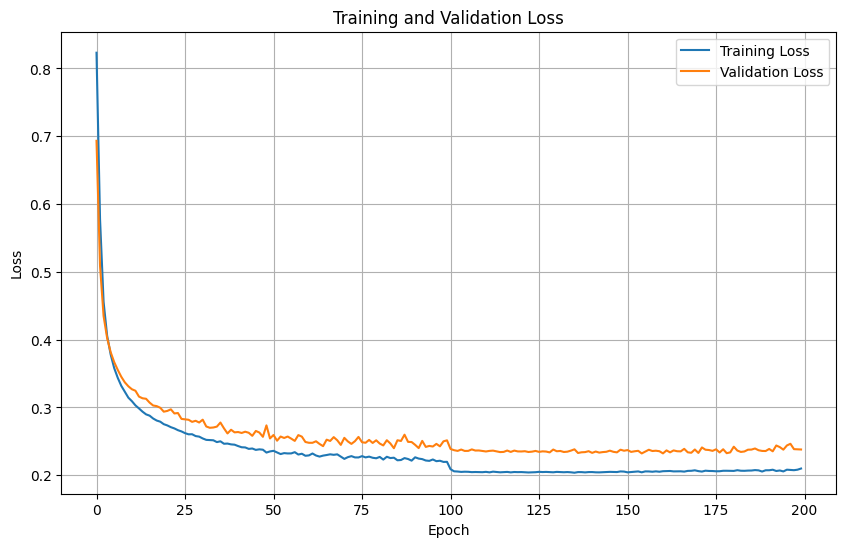

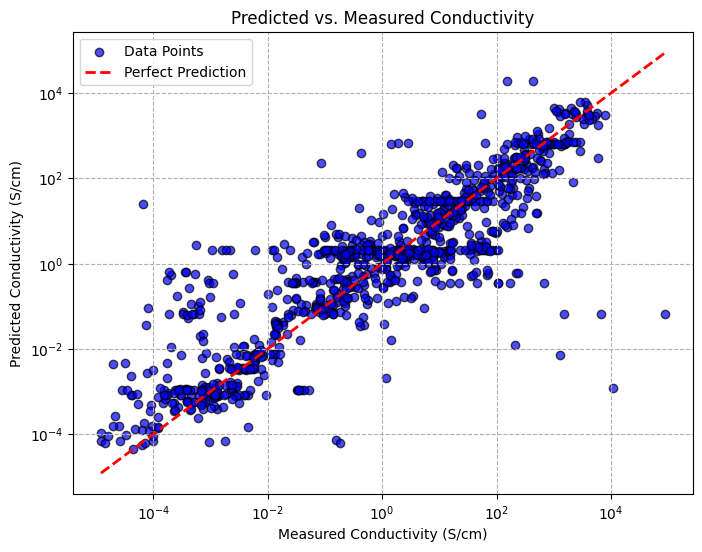

In [53]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Constants
num_entries = 30
feature_length = 1003
dos_length = 500
xrd_length = 500
max_compounds = 3

# Neural Network Architecture
class CompositionToConductivityMLP(nn.Module):
    def __init__(self, input_dim):
        super(CompositionToConductivityMLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 128)
        self.output = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        y_pred = self.output(x)
        return y_pred

# Data Preparation
features = []
conductivities = []

if not valid_data.empty:
    for _, row in valid_data.iterrows():
        compounds = row['xrf_compounds']
        concentrations = row['xrf_concentration']
        conductivity = row['fpm_conductivity']

        if conductivity > 0 and len(compounds) == len(concentrations):
            compound_matrices = []

            for compound, concentration in zip(compounds, concentrations):
                if compound in all_data:
                    compound_features = []

                    for entry in all_data[compound]:
                        entry_features = [
                            entry.get('Direct Gap (eV)', 0.0),
                            entry.get('Indirect Gap (eV)', 0.0),
                            entry.get('Formation Energy per Atom (eV)', 0.0)
                        ]

                        binned_dos = entry.get('Binned DOS', [])
                        if isinstance(binned_dos, dict):
                            binned_dos = np.array(binned_dos.get('Densities', []), dtype=np.float32)
                        elif isinstance(binned_dos, list):
                            binned_dos = np.array(binned_dos, dtype=np.float32)
                        else:
                            binned_dos = np.zeros(dos_length, dtype=np.float32)
                        binned_dos = np.pad(binned_dos, (0, max(0, dos_length - len(binned_dos))))[:dos_length]
                        entry_features.extend(binned_dos)

                        binned_xrd = entry.get('Binned XRD', [])
                        if isinstance(binned_xrd, dict):
                            binned_xrd = np.array(binned_xrd.get('Intensity', []), dtype=np.float32)
                        elif isinstance(binned_xrd, list):
                            binned_xrd = np.array(binned_xrd, dtype=np.float32)
                        else:
                            binned_xrd = np.zeros(xrd_length, dtype=np.float32)
                        binned_xrd = np.pad(binned_xrd, (0, max(0, xrd_length - len(binned_xrd))))[:xrd_length]
                        entry_features.extend(binned_xrd)

                        entry_features = np.array(entry_features, dtype=np.float32) * concentration
                        compound_features.append(entry_features)

                    if compound_features:
                        compound_matrix = np.vstack(compound_features)
                        compound_matrices.append(compound_matrix)

            if not compound_matrices:
                compound_matrices = [np.zeros((num_entries, feature_length), dtype=np.float32)]

            combined_features = np.vstack(compound_matrices)
            combined_features = np.pad(
                combined_features,
                ((0, max(0, num_entries - combined_features.shape[0])), (0, 0)),
                mode='constant'
            )[:num_entries]

            features.append(combined_features)
            conductivities.append(np.log10(conductivity))

# Convert to numpy arrays
X = np.array(features, dtype=np.float32)
y = np.array(conductivities, dtype=np.float32)
X[np.isnan(X)] = 0
X[np.isinf(X)] = 0
y[np.isnan(y)] = 0
y[np.isinf(y)] = 0
X = X.reshape(X.shape[0], -1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create model, optimizer, scheduler
input_dim = X_train_tensor.shape[1]
net = CompositionToConductivityMLP(input_dim)
optimizer = optim.Adam(net.parameters(), lr=1e-6)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2, eta_min=1e-5)
writer = SummaryWriter()

# Training
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    net.eval()
    with torch.no_grad():
        val_outputs = net(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    scheduler.step()
    writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)

    if (epoch + 1) % 10 == 0:
        torch.save(net.state_dict(), f"model_epoch_{epoch + 1}.pth")
        with torch.no_grad():
            sample_input = X_train_tensor[:1]
            activation = net(sample_input)
            writer.add_histogram('Neuron Activations', activation, epoch)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}')        

# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
writer.add_figure("Loss Curves", plt.gcf())


# Predictions
net.eval()
with torch.no_grad():
    y_pred_tensor = net(X_test_tensor)

y_pred = scaler_y.inverse_transform(y_pred_tensor.numpy().flatten().reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test_tensor.numpy().flatten().reshape(-1, 1)).flatten()
conductivity_pred = 10 ** y_pred
conductivity_actual = 10 ** y_test

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(conductivity_actual, conductivity_pred, color='blue', alpha=0.7, edgecolors='k', label='Data Points')
plt.plot([conductivity_actual.min(), conductivity_actual.max()],
         [conductivity_actual.min(), conductivity_actual.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Measured Conductivity (S/cm)')
plt.ylabel('Predicted Conductivity (S/cm)')
plt.title('Predicted vs. Measured Conductivity')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
writer.add_figure("Predicted vs. Measured Conductivity", plt.gcf())


writer.close()


In [19]:
## Discussion of "Smart Approach" vs. "Dumb AI"
#--> Low amounts of data --> smart approach, rely on human learning
#--> High amounts of data --> get enough data

#Can also use machine learning to impute // bridge the gap between 

In [ ]:
## Discussion of what else is possible

In [48]:
%load_ext tensorboard

In [49]:
import os
%tensorboard --logdir=runs  --host localhost --port=6067

# Practice: Explore the Materials Project Database

## 1) Accessing Material Structure Data Through the API

- **a)** Choose a set of inorganic elements to examine (e.g. Si-O, Mo-S-O, Li-Mn-Co-Ni-O, etc.) and explain your choice.
- **b)** Provide Python code using the API to find all compounds on the MP database for that composition – how many are there?
- **c)** Provide Python code to visualize at least one structure and calculate a structural metric (e.g. bond length distribution).

## 2) Accessing Property Data Through the API

- **a)** Choose a set of property data available on the MP database that is of interest to you and explain your choice.
- **b)** Provide Python code using the API to download this property data for all of the compounds of your target composition.
- **c)** Create visualizations showing how the property changes vs. one (or more) structural metric for all available data for this composition.


In [ ]:
# 1) Could we have gotten by with less data? Here, we included 10 entries for the target composition.
# a) Does the model improve when we only use three entries for the target composition?
# b) 